# TP 2024 – Méthodes pour l'analytique

## Documentation du problème

Nous souhaitons prédire l'ensemble des médailles susceptible d'être gagné par chaque pays lors de cette édition des Jeux Olympiques, en fonction des précédentes éditions qu'il y a déjà eu, répertorié dans l'ensemble des bases de données pour observer des corrélation importantes entre les vainqueurs et les éditions.

Pour résoudre ce problème, un modèle de régression (linéaire, logistique ...) semble adapté. Notamment une régression multivariée, car il est à prévoir que plusieurs variables pourraient influencer le nombre total de médailles qu'un pays pourrait remporter. Les caractéristiques telles que la population d'un pays, PIB ou les performances passées pourraient toutes être prises en compte pour prédire le nombre total de médailles. 

Forecasting the Olympic medal distribution – A socioeconomic machine learning model (Christoph Schlembach a, Sascha L. Schmidt a and al.)

Dans cette étude, les auteurs transposent le concept éprouvé du modèle Tobit à l'apprentissage automatique en utilisant un modèle Random Forest en deux étapes pour prédire les performances olympiques. 
De cette manière, ils identifient le premier modèle qui surpasse systématiquement un modèle de prévision naïf, lors de quatre Jeux d'été consécutifs (2008, 2012, 2016 et 2020), d'environ 3 à 6 points de pourcentage.

https://theconversation.com/olympic-medal-forecasting-its-easier-to-predict-results-than-you-might-think-62501

Dans cette article nous apprenons que seulement 3 variables seraient necessaires pour prédire à chaque fois les futurs Jeux Olympique qui sont : 
-La taille de la population : Si le talent sportif  est uniformément réparti dans la population mondiale, il s'ensuit que les grands pays comptent davantage d'athlètes ayant les meilleures aptitudes naturelles.
-Le PIB par habitants : Dans les pays où le PIB par habitant est plus élevé, la population est susceptible d'avoir plus de temps libre à consacrer au sport et il y aura de meilleures infrastructures et plus de financement pour l'entraînement des athlètes d'élite.
-Si le pays est le pays accueillant des JO : Le fait d'être le pays organisateur a été associé à un effet positif important sur le nombre de médailles d'un pays.

## Exploration des données

### import des données

In [2]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import * 
from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns
import sklearn

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error

data = pd.read_csv("data/athlete_events.csv")
df_pop = pd.read_csv("data/dictionary.csv")
df_noc = pd.read_csv("data/noc_regions.csv")

In [3]:
data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN


In [3]:
df_pop.head(1)

,Country,Code,Population,GDP per Capita
0,Afghanistan,AFG,32526562.0,594.323081


In [4]:
# vérification des données manquantes (pour savoir si notre analyse risque d'être impacté)
df_pop.isnull().sum()

Country            0
Code               0
Population         5
GDP per Capita    25
dtype: int64

In [5]:
df_noc.head(1)

,NOC,region,notes
0,AFG,Afghanistan,NaN


In [6]:
df_noc.isnull().sum()

NOC         0
region      3
notes     209
dtype: int64

In [7]:
df_noc[df_noc['region'].isnull()]

,NOC,region,notes
168,ROT,NaN,Refugee Olympic Team
208,TUV,NaN,Tuvalu
213,UNK,NaN,Unknown


Après recherches sur Internet, les 3 codes non connus correspondent à :
- Tuvalu pour TUV
- Réfugiés (Refugee Olympic Team) pour ROT
- Inconnus pour UNK

In [8]:
# on définit un dictionnaire des régions correspondantes pour les NOC inconnus
regions_inconnues = {'TUV': 'Tuvalu', 'UNK': 'Unknown', 'ROT': 'Refugee Olympic Team'}

# renseigner les régions pour les NOC inconnus dans df_noc
for noc, region in regions_inconnues.items():
    df_noc.loc[df_noc['NOC'] == noc, 'region'] = region

### Explication des 3 dataframe créés

data contient des données sur les athlètes ayant participés aux jeux olympiques, avec les données suivantes : 
- identifiant de l'athlète
- nom
- sexe
- âge
- taille
- poids
- pays (appelé équipe)
- code NOC (Comité national olympique) désignant le pays
- Jeux olympique (année et saison)
- année
- saison
- ville
- sport
- événement (sous-catégorie du sport)
- médaille remportée

df_pop contient un dictionnaire avec des informations sur les pays participants aux Jeux Olympiques contenant :
- le pays
- le code pays (NOC)
- la population 
- le PIB par habitant

df_noc contient des informations sur les codes NOC et les régions correspondantes.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


In [10]:
data.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

nos analyses basée sur l'âge peuvent être impactée par l'absence de donnée. Pour la même raison, nous éviterons les analyses en lien avec le poids ou la taille sans un traitement des valeurs manquantes au préalable.

In [11]:
profile = ProfileReport(data, title='Pandas Profiling Report')
profile.to_file("report-profiling-jo-dataset.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
pivot_ui(data)

In [13]:
data.Sport.unique().tolist()

['Basketball',
 'Judo',
 'Football',
 'Tug-Of-War',
 'Speed Skating',
 'Cross Country Skiing',
 'Athletics',
 'Ice Hockey',
 'Swimming',
 'Badminton',
 'Sailing',
 'Biathlon',
 'Gymnastics',
 'Art Competitions',
 'Alpine Skiing',
 'Handball',
 'Weightlifting',
 'Wrestling',
 'Luge',
 'Water Polo',
 'Hockey',
 'Rowing',
 'Bobsleigh',
 'Fencing',
 'Equestrianism',
 'Shooting',
 'Boxing',
 'Taekwondo',
 'Cycling',
 'Diving',
 'Canoeing',
 'Tennis',
 'Modern Pentathlon',
 'Figure Skating',
 'Golf',
 'Softball',
 'Archery',
 'Volleyball',
 'Synchronized Swimming',
 'Table Tennis',
 'Nordic Combined',
 'Baseball',
 'Rhythmic Gymnastics',
 'Freestyle Skiing',
 'Rugby Sevens',
 'Trampolining',
 'Beach Volleyball',
 'Triathlon',
 'Ski Jumping',
 'Curling',
 'Snowboarding',
 'Rugby',
 'Short Track Speed Skating',
 'Skeleton',
 'Lacrosse',
 'Polo',
 'Cricket',
 'Racquets',
 'Motorboating',
 'Military Ski Patrol',
 'Croquet',
 'Jeu De Paume',
 'Roque',
 'Alpinism',
 'Basque Pelota',
 'Aeronautics'

### Visualisation pour comprendre la distribution des médailles

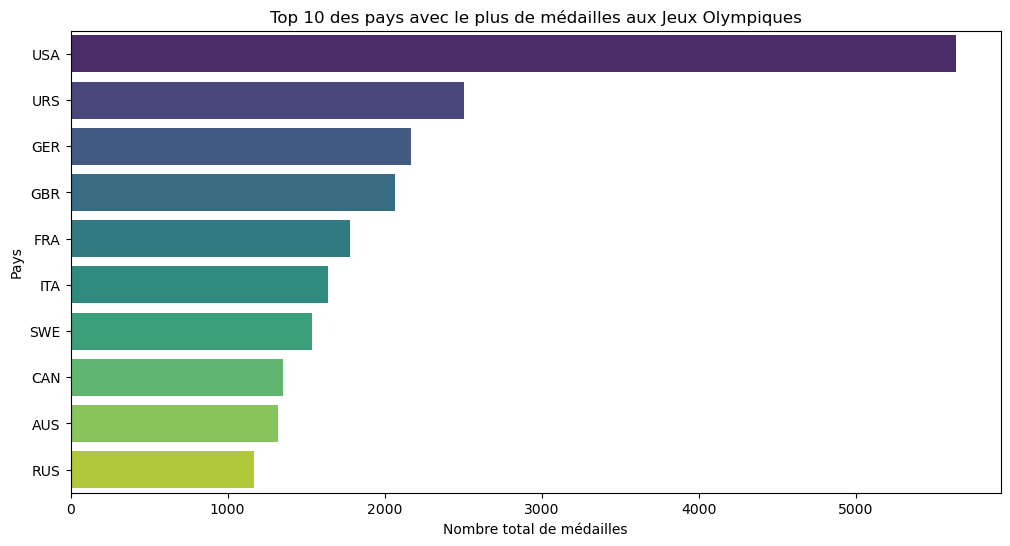

In [14]:
# Distribution des médailles par pays
plt.figure(figsize=(12, 6))
top_countries = data.groupby('NOC')['Medal'].count().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.xlabel('Nombre total de médailles')
plt.ylabel('Pays')
plt.title('Top 10 des pays avec le plus de médailles aux Jeux Olympiques')
plt.show()

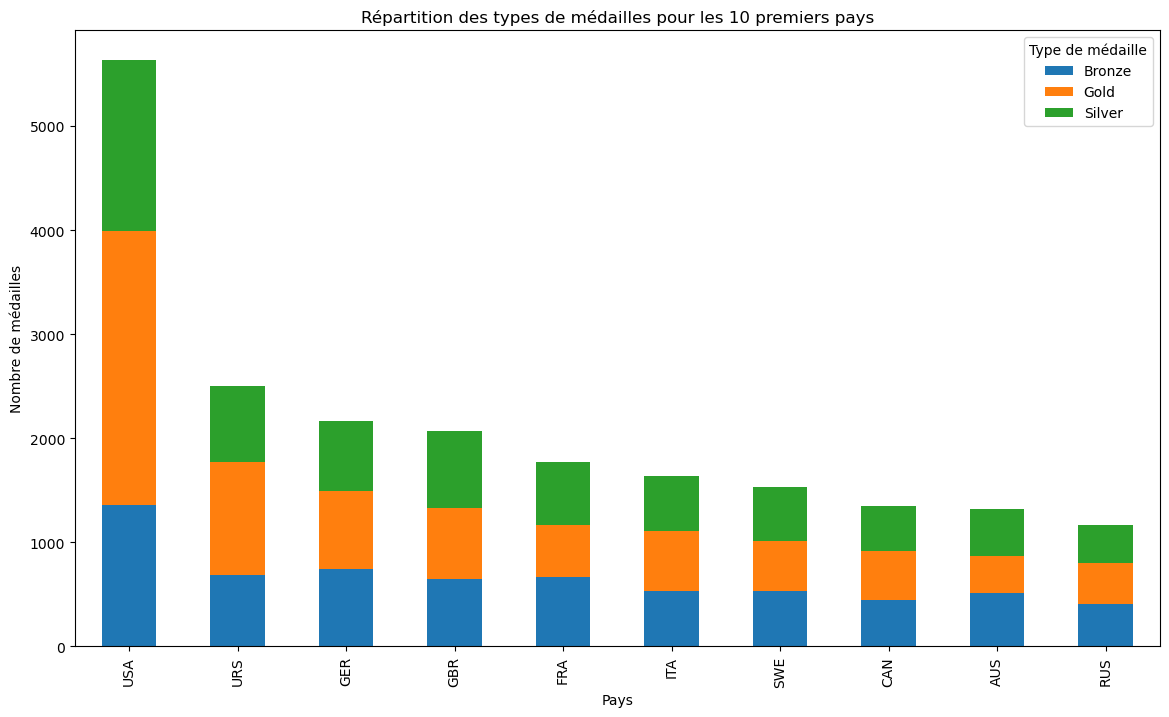

In [5]:
# Filtrer les lignes par médailles (en ne prenant pas en compte les valeurs nulles) et compter les médailles par type et par pays
medals_by_type_country = data.dropna(subset=['Medal']).groupby(['NOC', 'Medal']).size().unstack(fill_value=0)

# Calculer le total de médailles par pays pour obtenir les 10 premiers pays
medals_by_type_country['Total'] = medals_by_type_country.sum(axis=1)
top_countries = medals_by_type_country.sort_values('Total', ascending=False).head(10)

# Supprimer la colonne total pour la visualisation
top_countries = top_countries.drop(columns='Total')


top_countries.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Répartition des types de médailles pour les 10 premiers pays')
plt.xlabel('Pays')
plt.ylabel('Nombre de médailles')
plt.legend(title='Type de médaille')
plt.show()

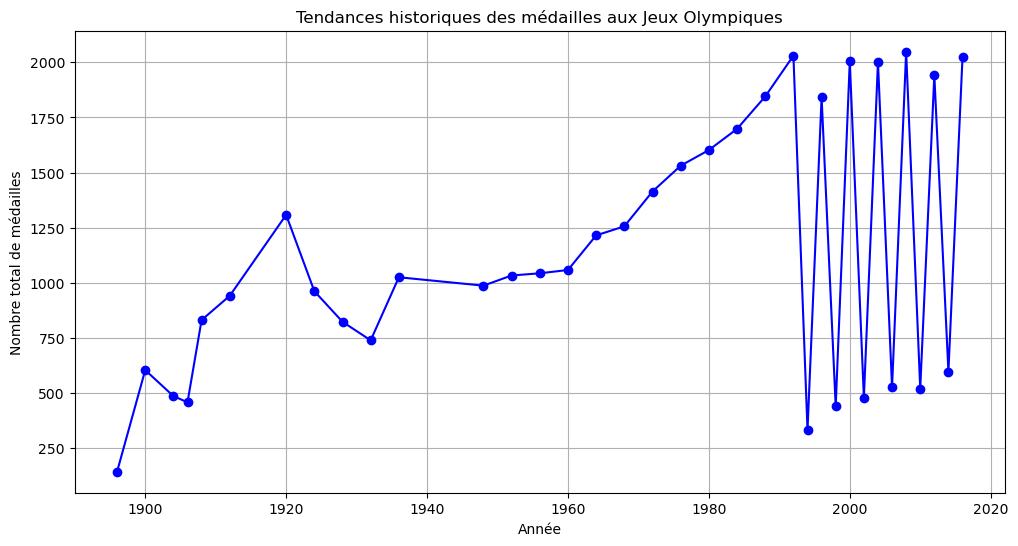

In [16]:
# Tendances historiques des médailles gagnées
plt.figure(figsize=(12, 6))
medals_per_year = data.groupby('Year')['Medal'].count()
medals_per_year.plot(kind='line', marker='o', color='b')
plt.xlabel('Année')
plt.ylabel('Nombre total de médailles')
plt.title('Tendances historiques des médailles aux Jeux Olympiques')
plt.grid(True)
plt.show()

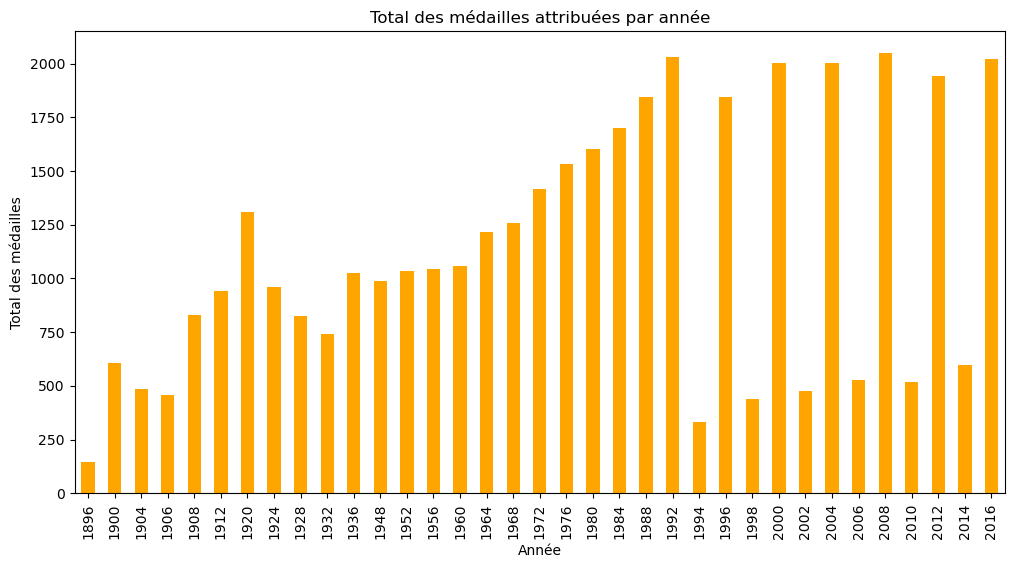

In [17]:
# Total des médailles par année
plt.figure(figsize=(12, 6))
total_medals_per_year = data.groupby('Year')['Medal'].count()
total_medals_per_year.plot(kind='bar', color='orange')
plt.xlabel('Année')
plt.ylabel('Total des médailles')
plt.title('Total des médailles attribuées par année')
plt.show()

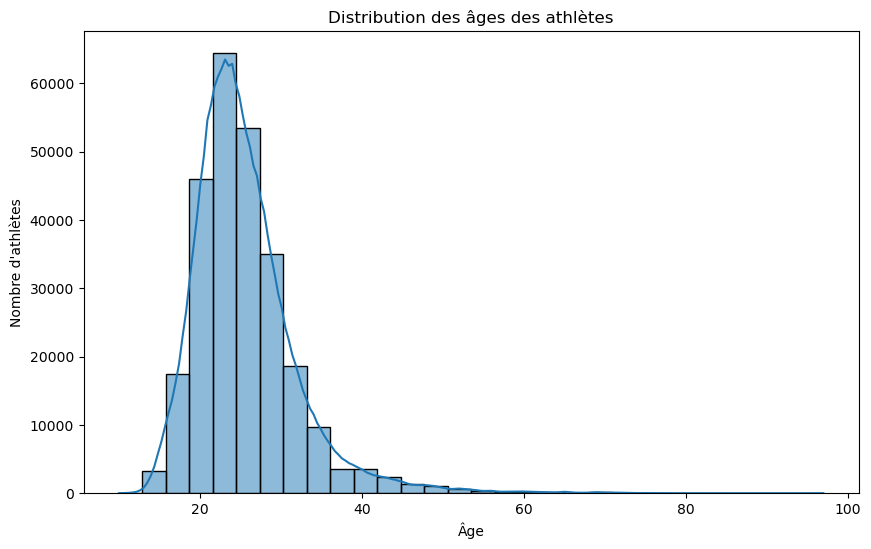

In [18]:
# Préparation des données
medals_by_country = data.dropna(subset=['Medal']).groupby('NOC')['Medal'].count().sort_values(ascending=False).head(10)
participants_by_year = data.groupby('Year')['ID'].nunique()

# Distribution des âges des athlètes
plt.figure(figsize=(10, 6))
sns.histplot(data['Age'].dropna(), bins=30, kde=True)
plt.title('Distribution des âges des athlètes')
plt.xlabel('Âge')
plt.ylabel('Nombre d\'athlètes')
plt.show()

In [19]:
# Compter le nombre de médaille par sexe
data.groupby('Sex')['Medal'].count()

Sex
F    11253
M    28530
Name: Medal, dtype: int64

In [20]:
data['Age'].describe()

count    261642.000000
mean         25.556898
std           6.393561
min          10.000000
25%          21.000000
50%          24.000000
75%          28.000000
max          97.000000
Name: Age, dtype: float64

In [21]:
data['Height'].describe()

count    210945.000000
mean        175.338970
std          10.518462
min         127.000000
25%         168.000000
50%         175.000000
75%         183.000000
max         226.000000
Name: Height, dtype: float64

In [22]:
data['Weight'].describe()

count    208241.000000
mean         70.702393
std          14.348020
min          25.000000
25%          60.000000
50%          70.000000
75%          79.000000
max         214.000000
Name: Weight, dtype: float64

In [23]:
data['AgeGroup'] = pd.cut(data.Age, range(0, 101, 10), right=True,\
                        labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80','81-90','91-100'])

data['HeightGroup'] = pd.cut(data.Height, bins=range(127, 228, 10), right=False,
                        labels=['127-136', '137-146', '147-156', '157-166', '167-176', '177-186', '187-196', '197-206','207-216','217-227'])

data['WeightGroup'] = pd.cut(data.Weight, bins=range(25, 226, 20), right=False,
                        labels=['25-44', '45-64', '65-84', '85-104', '105-124', '125-144', '145-164', '165-184','185-204','205-225'])

In [24]:
attrs = ['Sex', 'AgeGroup', 'HeightGroup', 'WeightGroup', 'Season']

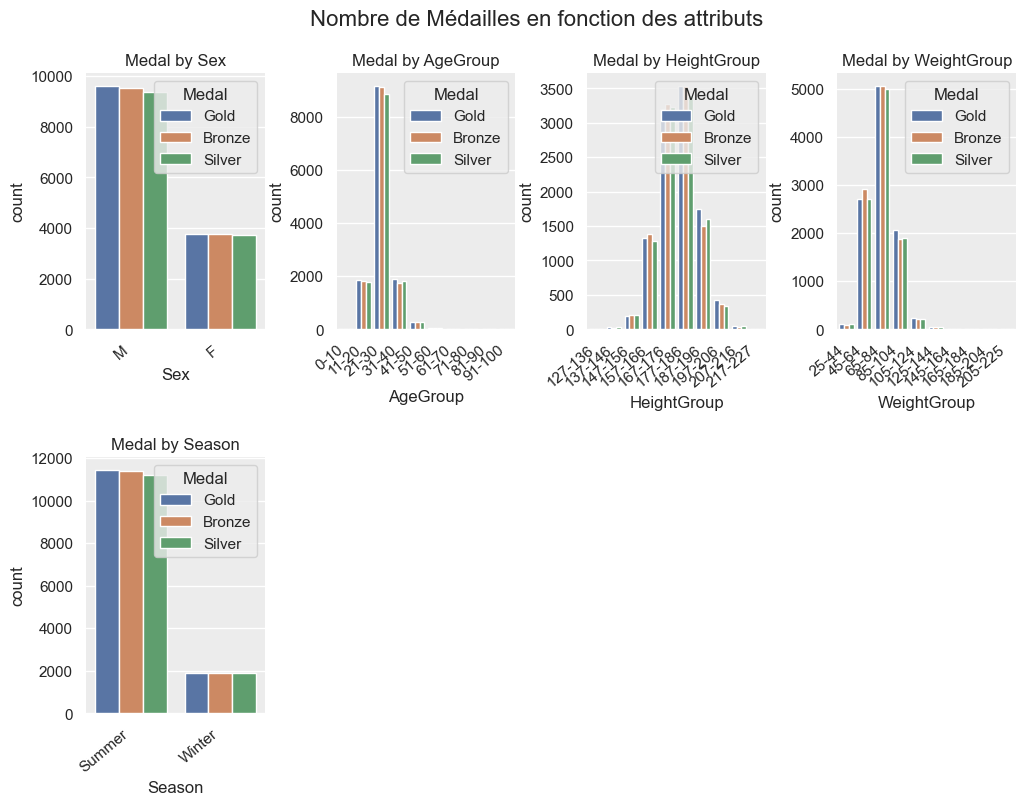

In [25]:
# EDA avec seaborn
sns.set(style="dark")

figure = plt.figure(figsize = (12, 8))
figure.suptitle('Nombre de Médailles en fonction des attributs', fontsize=16)
plt.rc('axes', facecolor='#ececec', edgecolor='none', axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')

plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=0.5, wspace=0.4)

for i, col in enumerate(attrs):
    plt.subplot(2, 4, i+1)
    plt.xticks(rotation=40, horizontalalignment='right')
    sns.countplot(x=col, hue='Medal', data=data).set_title('Medal by '+col)

plt.show()

### Analyse des visualisations générées

Les résultats montre un trop grand nombre de médailles gagnées par pays. En effet si nous prenons le cas des Etats Unis ils sont censé avoir gagné 2 963 médailles combiné (été + hiver) depuis 1896. 
Or notre graphique nous montre total de médailles de plus de 5 000 ainsi cela fausse les résultats et le classement des 10 premier pays.

Pour cause, il existe 2 problèmes : 

Sports collectifs : Les sports collectifs, tels que le basketball, le football ..., attribuent une seule médaille d'or, d'argent et de bronze à l'équipe gagnante, plutôt qu'à chaque membre individuel de l'équipe. Par conséquent, lorsque nous calculons les médailles par pays, nous devons tenir compte de cette distinction. Plutôt que d'attribuer chaque médaille à chaque athlète, une seule médaille est attribuée à l'équipe et donc au pays représenté par cette équipe.

Évolutions des dénominations des pays : Les noms et les dénominations des pays peuvent évoluer avec le temps en raison de changements politiques, de fusions ou de séparations de territoires, ou d'autres facteurs. Lorsque nous analysons les performances historiques des pays aux Jeux Olympiques, il est important de normaliser les données pour tenir compte de ces changements. Par exemple, si un pays se divise en deux, les performances de ses athlètes peuvent être attribuées à deux nouveaux pays distincts.

En tenant compte de ces aspects, nous pouvons tirer les conclusions suivantes :

Lorsque nous calculons les médailles par pays, nous devons être conscients que les médailles des sports collectifs représentent une seule médaille pour le pays concerné, même si elles sont remportées par plusieurs athlètes.

Pour analyser les tendances historiques, il est important de normaliser les données pour tenir compte des évolutions des dénominations des pays. Cela garantit que les performances des athlètes sont correctement attribuées aux pays pertinents, même en cas de changements dans la structure politique ou géographique.

En résumé, une analyse précise des médailles par pays nécessite de prendre en compte les distinctions entre les sports individuels et collectifs, ainsi que de normaliser les données pour tenir compte des évolutions des dénominations des pays. Cela garantit que nos conclusions reflètent fidèlement les performances des pays aux Jeux Olympiques.

In [26]:
# Trouver les noms de pays uniques dans le jeu de données
unique_countries = data['NOC'].unique()

changed_countries = []

for country in unique_countries:
    if len(data[data['NOC'] == country]['Team'].unique()) > 1:
        changed_countries.append(country)

print("Pays qui ont changé de nom :")
for country in changed_countries:
    print(country)

Pays qui ont changé de nom :
CHN
DEN
NED
USA
FIN
NOR
ROU
EST
FRA
ESP
BUL
ITA
RUS
ARG
CUB
BLR
GRE
TUR
CHI
MEX
URS
HUN
NGR
LIB
MAS
GER
CAN
IRL
AUS
RSA
BEL
IND
INA
PHI
SGP
UZB
EUN
JPN
SUI
BRA
FRG
GDR
MON
ISR
URU
SWE
ISV
UKR
GBR
LAT
POL
SLO
NZL
POR
VEN
COL
PUR
MRI
TCH
LUX
CZE
TTO
JAM
AUT
HAI
MLT
KOR
THA
BER
ANZ
YUG
BAH
SRB
SVK
CAM
PRK
ZIM
HKG
MYA
RHO
TPE
BOH
WIF


### Création d'un nouveau dataframe pour visualisations plus précises

In [27]:
new_data = pd.merge(data, df_noc, on='NOC', how='left')
new_data.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,AgeGroup,HeightGroup,WeightGroup,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,21-30,177-186,65-84,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,21-30,167-176,45-64,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,21-30,NaN,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,31-40,NaN,NaN,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,21-30,177-186,65-84,Netherlands,NaN


In [28]:
new_data.drop(['AgeGroup','HeightGroup','WeightGroup'], axis=1, inplace=True)

In [29]:
new_data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN,Poland,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN,Poland,NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN,Poland,NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN,Poland,NaN


In [30]:
gold = new_data[(new_data.Medal == 'Gold')]
gold.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
42,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Team All-Around,Gold,Finland,NaN
44,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Horse Vault,Gold,Finland,NaN
48,17,Paavo Johannes Aaltonen,M,28.0,175.0,64.0,Finland,FIN,1948 Summer,1948,Summer,London,Gymnastics,Gymnastics Men's Pommelled Horse,Gold,Finland,NaN
60,20,Kjetil Andr Aamodt,M,20.0,176.0,85.0,Norway,NOR,1992 Winter,1992,Winter,Albertville,Alpine Skiing,Alpine Skiing Men's Super G,Gold,Norway,NaN


In [31]:
gold_ages = gold[np.isfinite(gold['Age'])]

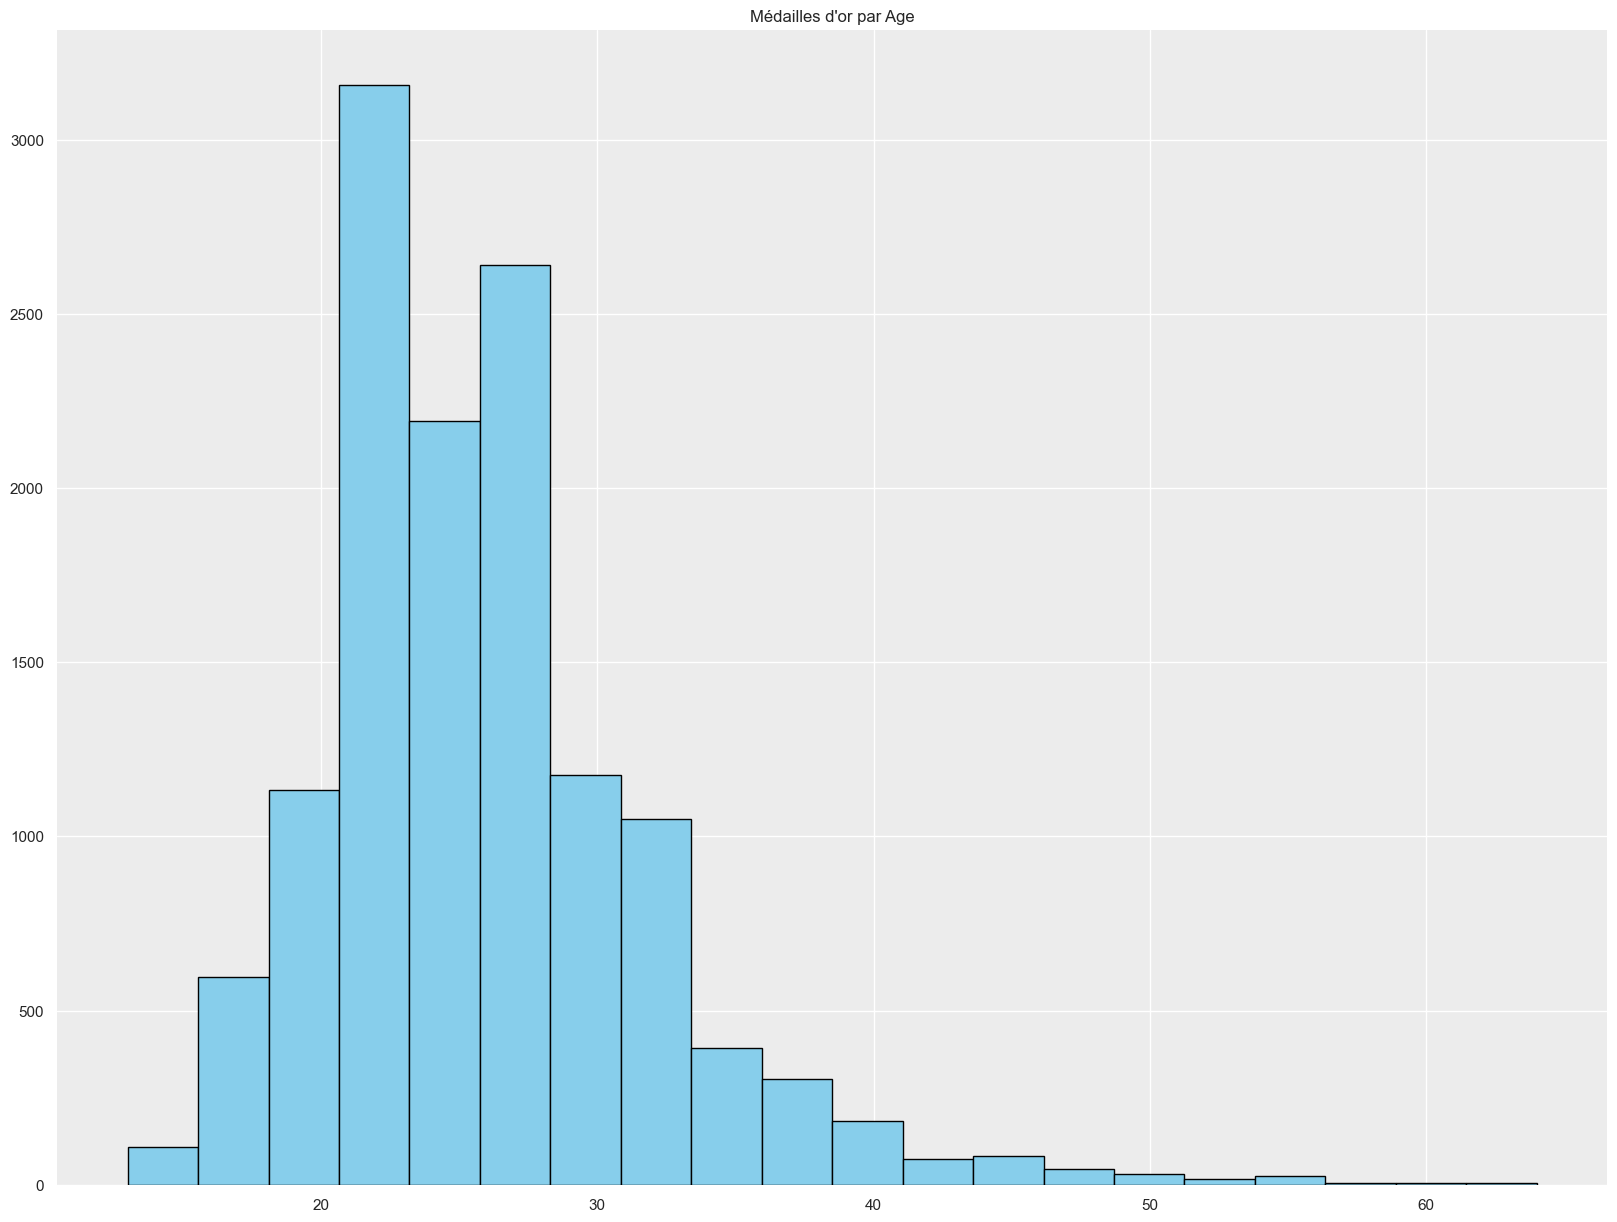

In [32]:
plt.figure(figsize=(20, 15))
plt.hist(gold_ages['Age'], bins=20, color='skyblue', edgecolor='black')
plt.title('Médailles d\'or par Age')
plt.grid(True)
plt.show()

In [33]:
# Compter les athlètes de plus de 50 ans ayant reçu une médaille
gold['ID'][gold['Age']> 50].count()

65

In [34]:
# Occurence des villes hôtes
cities = new_data.groupby('City').apply(lambda x:x['Year'].unique()).to_frame().reset_index()
cities.columns = ['City','Years']
cities['Occurence'] = [len(c) for c in cities['Years']]
cities.sort_values('Occurence', ascending = False)

,City,Years,Occurence
3,Athina,"[2004, 1906, 1896]",3
17,London,"[2012, 1948, 1908]",3
30,Sankt Moritz,"[1928, 1948]",2
26,Paris,"[1900, 1924]",2
37,Stockholm,"[1912, 1956]",2
18,Los Angeles,"[1932, 1984]",2
15,Lake Placid,"[1980, 1932]",2
14,Innsbruck,"[1964, 1976]",2
0,Albertville,[1992],1
27,Rio de Janeiro,[2016],1


In [35]:
diff_seasons = new_data.Season.value_counts()
diff_seasons

Season
Summer    222552
Winter     48564
Name: count, dtype: int64

In [36]:
# Création dataframe jeux d'été
df_summer = new_data[new_data['Season'] == 'Summer']
df_summer

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN,China,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN,China,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN,Denmark,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,NaN
26,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.0,NaN,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NaN,Netherlands,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271106,135565,Fernando scar Zylberberg,M,27.0,168.0,76.0,Argentina,ARG,2004 Summer,2004,Summer,Athina,Hockey,Hockey Men's Hockey,NaN,Argentina,NaN
271107,135566,"James Francis ""Jim"" Zylker",M,21.0,175.0,75.0,United States,USA,1972 Summer,1972,Summer,Munich,Football,Football Men's Football,NaN,USA,NaN
271108,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.0,Russia,RUS,2000 Summer,2000,Summer,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,NaN,Russia,NaN
271109,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.0,Russia,RUS,2004 Summer,2004,Summer,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,NaN,Russia,NaN


In [37]:
# Répartition des athlètes par sexe pour les jeux d'été
sex_summer = df_summer.groupby(['Sex','Year']).size().reset_index().pivot(columns='Sex', index='Year', values=0).reset_index()
sex_summer

Sex,Year,F,M
0,1896,NaN,380.0
1,1900,33.0,1903.0
2,1904,16.0,1285.0
3,1906,11.0,1722.0
4,1908,47.0,3054.0
5,1912,87.0,3953.0
6,1920,134.0,4158.0
7,1924,244.0,4989.0
8,1928,404.0,4588.0
9,1932,347.0,2622.0


In [38]:
# Création dataframe jeux d'hiver
df_winter =  new_data[new_data['Season'] == 'Winter']
df_winter

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN,Netherlands,NaN
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",NaN,Netherlands,NaN
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,Poland-1,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,NaN,Poland,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",NaN,Poland,NaN
271113,135570,Piotr ya,M,27.0,176.0,59.0,Poland,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",NaN,Poland,NaN
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,Poland,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,NaN,Poland,NaN


In [39]:
# Répartition des athlètes par sexe pour les jeux d'hiver
sex_winter = df_winter.groupby(['Sex','Year']).size().reset_index().pivot(columns='Sex', index='Year', values=0).reset_index()
sex_winter

Sex,Year,F,M
0,1924,17,443
1,1928,33,549
2,1932,22,330
3,1936,81,814
4,1948,133,942
5,1952,185,903
6,1956,246,1061
7,1960,295,821
8,1964,404,1374
9,1968,416,1475


In [40]:
women_JO = new_data[(new_data.Sex == 'F')]
women_JO

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",NaN,Netherlands,NaN
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",NaN,Netherlands,NaN
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,NaN,Netherlands,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271080,135553,Galina Ivanovna Zybina (-Fyodorova),F,33.0,168.0,80.0,Soviet Union,URS,1964 Summer,1964,Summer,Tokyo,Athletics,Athletics Women's Shot Put,Bronze,Russia,NaN
271099,135560,Stavroula Zygouri,F,36.0,171.0,63.0,Greece,GRE,2004 Summer,2004,Summer,Athina,Wrestling,"Wrestling Women's Middleweight, Freestyle",NaN,Greece,NaN
271102,135563,Olesya Nikolayevna Zykina,F,19.0,171.0,64.0,Russia,RUS,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Women's 4 x 400 metres Relay,Bronze,Russia,NaN
271103,135563,Olesya Nikolayevna Zykina,F,23.0,171.0,64.0,Russia,RUS,2004 Summer,2004,Summer,Athina,Athletics,Athletics Women's 4 x 400 metres Relay,Silver,Russia,NaN


Text(0.5, 1.0, 'Nombre de médailles obtenue seulement par des femmes')

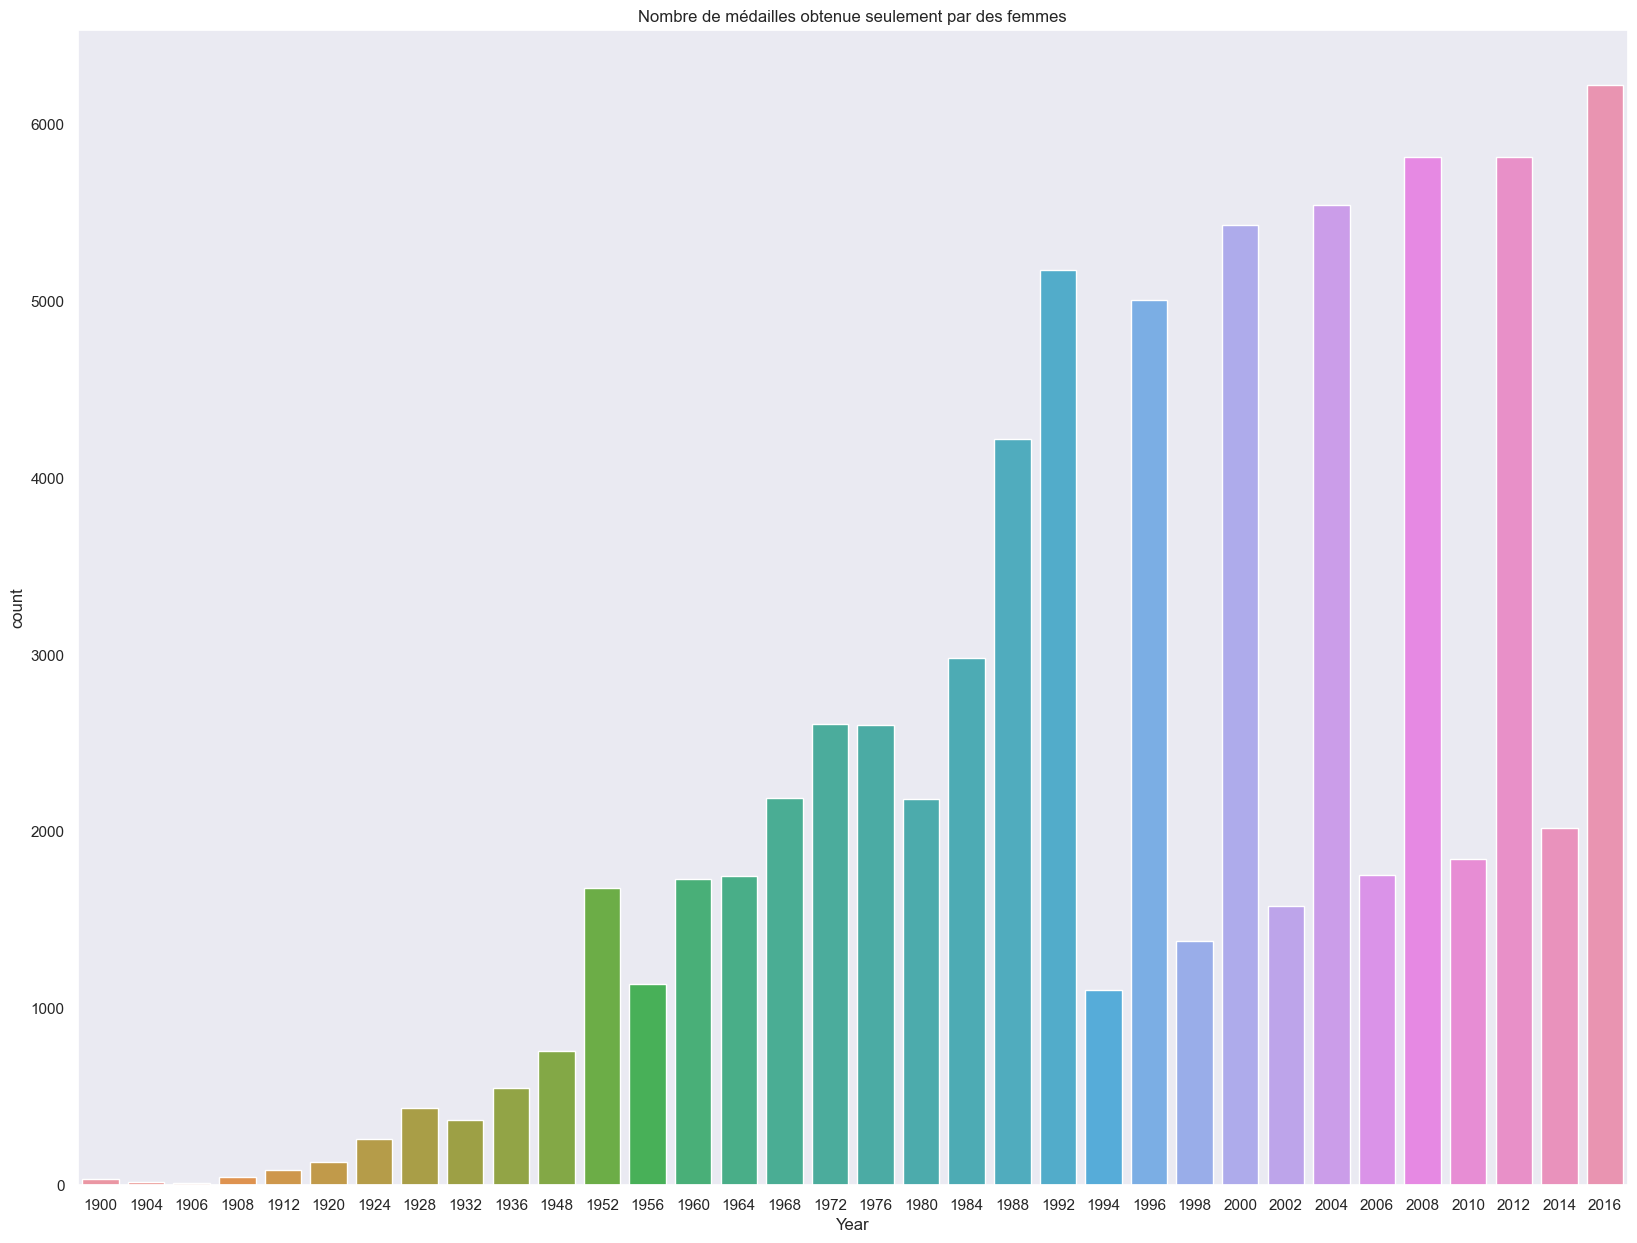

In [41]:
sns.set(style = 'dark')
plt.figure(figsize = (20, 15))
sns.countplot(x = 'Year', data= women_JO)
plt.title('Nombre de médailles obtenue seulement par des femmes')

Text(0.5, 1.0, 'Nombre de médailles obtenue seulement par des hommes')

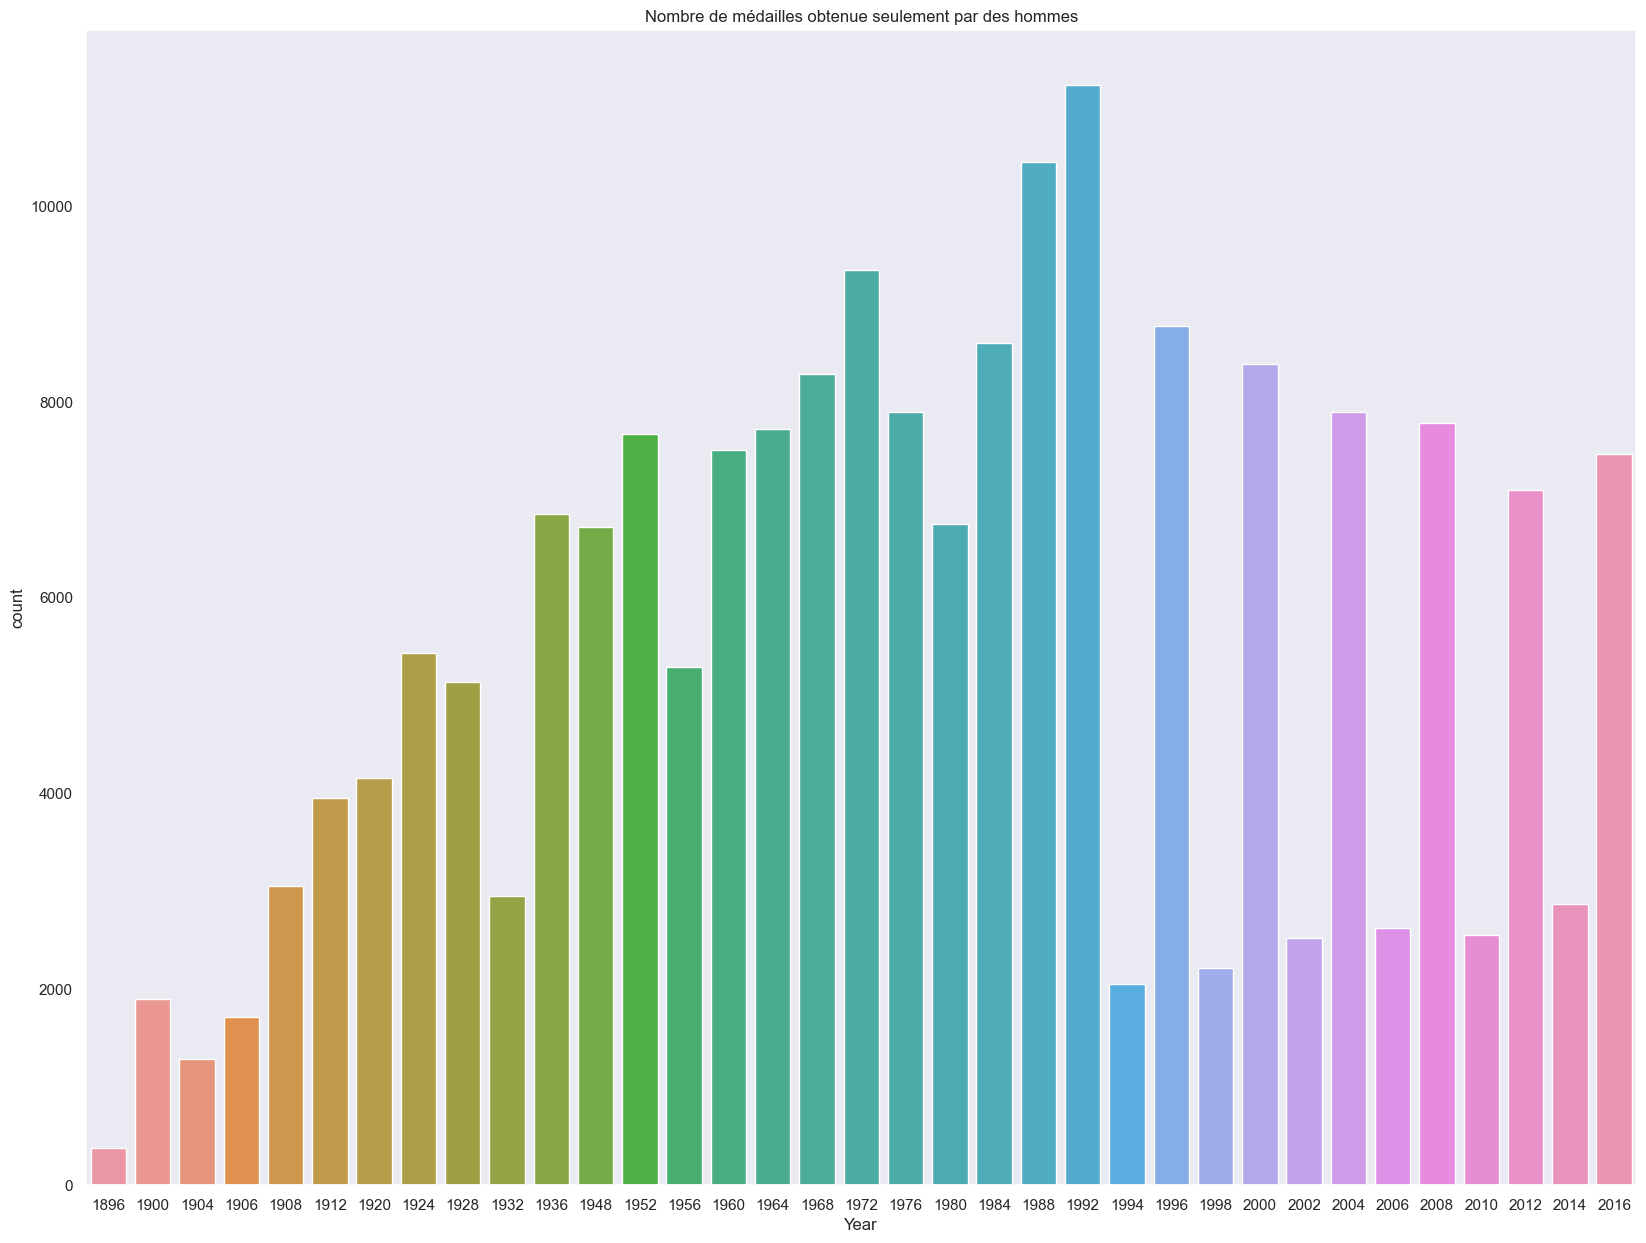

In [42]:
men_JO = new_data[(new_data.Sex == 'M')]
men_JO

sns.set(style = 'dark')
plt.figure(figsize = (20, 15))
sns.countplot(x = 'Year', data= men_JO)
plt.title('Nombre de médailles obtenue seulement par des hommes')

Les femmes gagnent de plus en plus de médailles, surtout depuis les jeux de 1988. Le phénomène inverse est présent pour les athlètes masculins

In [43]:
# Répartition des médailles d'or pour les jeux les plus récents de notre dataset
country_2016 = new_data[(new_data.Year == 2016) & (new_data.Medal =='Gold')].Team
country_2016.value_counts().head(10)

Team
United States    137
Great Britain     64
Russia            50
Germany           47
China             44
Brazil            34
Australia         23
Argentina         21
France            20
Japan             17
Name: count, dtype: int64

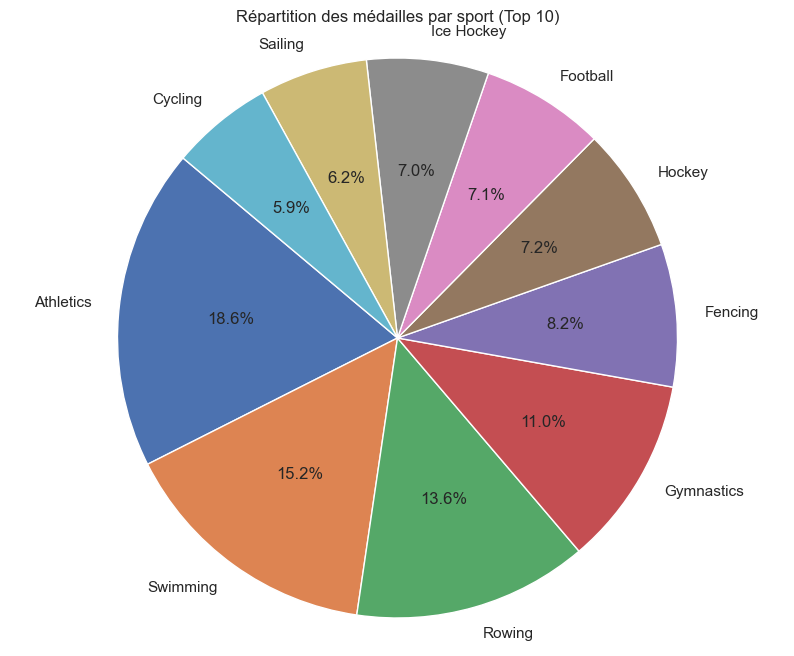

In [44]:
top_sports = gold['Sport'].value_counts().head(10)

plt.figure(figsize=(10, 8))
plt.pie(top_sports, labels=top_sports.index, autopct='%1.1f%%', startangle=140)
plt.title('Répartition des médailles par sport (Top 10)')
plt.axis('equal') 
plt.show()

## Recherche de données complémentaires

In [45]:
import requests
from bs4 import BeautifulSoup

In [46]:
# Choix d'un site qui nous paraît pertinent et dont le tableau peut servir à nos analyses
url = 'https://www.olympedia.org/statistics/medal/country'

In [47]:
response = requests.get(url)

In [48]:
soup = BeautifulSoup(response.text, 'html.parser')

In [49]:
data = []

In [50]:
# Le nom de la classe vient du code html du site
medal_tables = soup.find_all('table', class_='table table-striped')

In [51]:
# Boucle iterative pour récupérer chaque ligne du tableau
for table in medal_tables:

    rows = table.find_all('tr')
    for row in rows:

        row.find_all('td')
        cells = row.find_all('td')
        row_data = [cell.text.strip() for cell in cells]  
        data.append(row_data)    

In [52]:
# Afficher les données extraites
for row in data:
    print(row)

[]
['United States', 'USA', '1229', '1000', '876', '3105']
['Soviet Union', 'URS', '473', '376', '355', '1204']
['Germany', 'GER', '384', '419', '408', '1211']
["People's Republic of China", 'CHN', '384', '281', '235', '900']
['Great Britain', 'GBR', '325', '352', '359', '1036']
['France', 'FRA', '312', '335', '392', '1039']
['Italy', 'ITA', '299', '278', '308', '885']
['Russian Federation', 'RUS', '290', '243', '246', '779']
['Sweden', 'SWE', '233', '245', '262', '740']
['Japan', 'JPN', '229', '220', '241', '690']
['Norway', 'NOR', '221', '205', '191', '617']
['Hungary', 'HUN', '210', '183', '208', '601']
['East Germany', 'GDR', '192', '165', '162', '519']
['Australia', 'AUS', '185', '204', '247', '636']
['Republic of Korea', 'KOR', '166', '144', '137', '447']
['Netherlands', 'NED', '159', '166', '187', '512']
['Canada', 'CAN', '157', '197', '250', '604']
['Finland', 'FIN', '155', '157', '195', '507']
['Switzerland', 'SUI', '142', '146', '153', '441']
['Elis', 'ELI', '117', '0', '0', 

In [53]:
# Sauvegarde des données dans un fichier CSV
with open('medals_data.csv', 'w') as f:
    for row in data:
        f.write(','.join(row) + '\n')

In [54]:
# Création d'un dataframe pour récupérer le tableau
df_scrapped = pd.DataFrame(data, columns=['Country','NOC', 'Gold', 'Silver', 'Bronze', 'Total'])

In [55]:
df_scrapped

,Country,NOC,Gold,Silver,Bronze,Total
0,None,None,None,None,None,None
1,United States,USA,1229,1000,876,3105
2,Soviet Union,URS,473,376,355,1204
3,Germany,GER,384,419,408,1211
4,People's Republic of China,CHN,384,281,235,900
...,...,...,...,...,...,...
333,Burkina Faso,BUR,0,0,1,1
334,Cambodia,CAM,0,0,1,1
335,Guyana,GUY,0,0,1,1
336,Honduras,HON,0,0,1,1


In [56]:
# Moyen le plus simple de corriger l'erreur, faute de compréhension de sa source
df_scrapped.drop(index=0,inplace=True)

In [57]:
# Dataframe de répartition des médailles par pays sur l'ensemble des JO avec distinction des types de médailles
df_scrapped

,Country,NOC,Gold,Silver,Bronze,Total
1,United States,USA,1229,1000,876,3105
2,Soviet Union,URS,473,376,355,1204
3,Germany,GER,384,419,408,1211
4,People's Republic of China,CHN,384,281,235,900
5,Great Britain,GBR,325,352,359,1036
...,...,...,...,...,...,...
333,Burkina Faso,BUR,0,0,1,1
334,Cambodia,CAM,0,0,1,1
335,Guyana,GUY,0,0,1,1
336,Honduras,HON,0,0,1,1


## Prétraitement des données : traitement des valeurs manquantes et aberrantes

In [58]:
new_data.isnull().sum() #Recherche de données complémentaires

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
region       349
notes     266077
dtype: int64

Pour Age, Height et Weight nous pouvons remplacer les valeurs manquantes par la moyenne de chaque colonnes pour éviter de fausser les résultats, mais nous estimons qu'il est plus judicieux d'utiliser un Imputer. Cependant après plusieurs test il est beaucoup trop long d'incorporer un imputer au vu du nombre de valeurs manquantes.

In [59]:
new_data['Age'] = new_data['Age'].fillna(new_data['Age'].mean())
new_data['Height'] = new_data['Height'].fillna(new_data['Height'].mean())
new_data['Weight'] = new_data['Weight'].fillna(new_data['Weight'].mean())

In [60]:
new_data.isnull().sum()

ID             0
Name           0
Sex            0
Age            0
Height         0
Weight         0
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
region       349
notes     266077
dtype: int64

Concernant les médailles, la plupart des athlètes n'ont pas gagnés de médailles ils faut remplacer les NaN par 'NW' Not Win.

In [61]:
new_data['Medal'].fillna('NW', inplace=True)

In [62]:
new_data.notes.unique()

array([nan, 'United Arab Republic', 'North Yemen', 'Virgin Islands',
       'Turks and Caicos Islands', 'Trinidad and Tobago',
       'Netherlands Antilles', 'South Yemen', 'Australasia',
       'Serbia and Montenegro', 'Individual Olympic Athletes',
       'Yugoslavia', 'Refugee Olympic Team', 'Crete',
       'Antigua and Barbuda', 'Hong Kong', 'Bohemia',
       'West Indies Federation', 'North Borneo', 'Unknown', 'Tuvalu',
       'Newfoundland'], dtype=object)

In [63]:
new_data.region.unique()

array(['China', 'Denmark', 'Netherlands', 'USA', 'Finland', 'Norway',
       'Romania', 'Estonia', 'France', 'Morocco', 'Spain', 'Egypt',
       'Iran', 'Bulgaria', 'Italy', 'Chad', 'Azerbaijan', 'Sudan',
       'Russia', 'Argentina', 'Cuba', 'Belarus', 'Greece', 'Cameroon',
       'Turkey', 'Chile', 'Mexico', 'Nicaragua', 'Hungary', 'Nigeria',
       'Algeria', 'Kuwait', 'Bahrain', 'Pakistan', 'Iraq', 'Syria',
       'Lebanon', 'Qatar', 'Malaysia', 'Germany', 'Canada', 'Ireland',
       'Australia', 'South Africa', 'Eritrea', 'Tanzania', 'Jordan',
       'Tunisia', 'Libya', 'Belgium', 'Djibouti', 'Palestine', 'Comoros',
       'Kazakhstan', 'Brunei', 'India', 'Saudi Arabia', 'Maldives',
       'Ethiopia', 'United Arab Emirates', 'Yemen', 'Indonesia',
       'Philippines', nan, 'Uzbekistan', 'Kyrgyzstan', 'Tajikistan',
       'Japan', 'Republic of Congo', 'Switzerland', 'Brazil', 'Monaco',
       'Israel', 'Uruguay', 'Sweden', 'Virgin Islands, US', 'Sri Lanka',
       'Armenia', 'Ivory

In [64]:
new_data['notes'].fillna('U', inplace=True) #U pour Unknown
new_data['region'].fillna('U', inplace=True)

In [65]:
new_data.isnull().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
region    0
notes     0
dtype: int64

<Axes: >

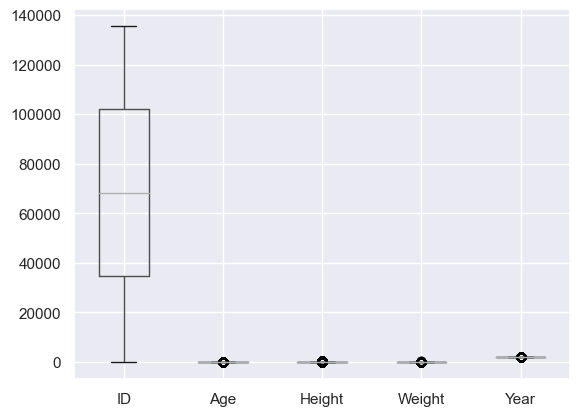

In [66]:
new_data.boxplot()

<Axes: >

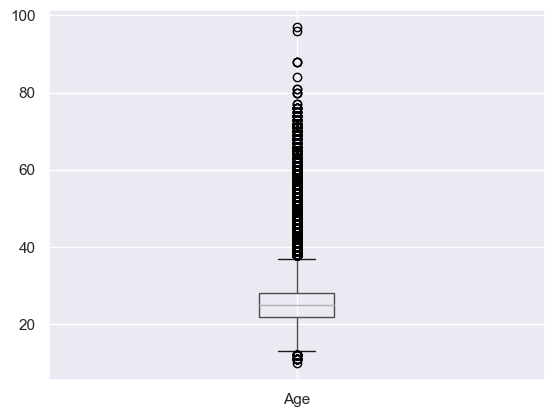

In [67]:
new_data.boxplot(column='Age',return_type='axes')

In [68]:
cols = ['Age']
low = .05
high = .99 #Return values at the given quantile  0.99 (99% quantile)
quant_data =  new_data[cols].quantile([low, high])
print(quant_data)

       Age
0.05  18.0
0.99  48.0


In [69]:
higher = quant_data.loc[high,'Age']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

new_data['Age'] = new_data['Age'].apply(func)

In [70]:
new_data[new_data['Age'].ge(quant_data.loc[high,'Age'])]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
58,19,Win Valdemar Aaltonen,M,48.0,175.33897,70.702393,Finland,FIN,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Sculpturing, Unknown Event",NW,Finland,U
127,46,Hans Aasns,M,48.0,194.00000,93.000000,Norway,NOR,1952 Summer,1952,Summer,Helsinki,Shooting,Shooting Men's Trap,NW,Norway,U
128,46,Hans Aasns,M,48.0,194.00000,93.000000,Norway,NOR,1956 Summer,1956,Summer,Melbourne,Shooting,Shooting Men's Trap,NW,Norway,U
129,46,Hans Aasns,M,48.0,194.00000,93.000000,Norway,NOR,1960 Summer,1960,Summer,Roma,Shooting,Shooting Men's Trap,NW,Norway,U
697,398,Roger Abel,M,48.0,175.33897,70.702393,Monaco,MON,1948 Summer,1948,Summer,London,Shooting,"Shooting Men's Small-Bore Rifle, Prone, 50 metres",NW,Monaco,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269857,135019,Christian Zimmermann,M,48.0,175.33897,70.702393,Palestine,PLE,2016 Summer,2016,Summer,Rio de Janeiro,Equestrianism,"Equestrianism Mixed Dressage, Individual",NW,Palestine,U
269998,135073,Doris Clare Zinkeisen (-Johnstone),F,48.0,175.33897,70.702393,Great Britain,GBR,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NW,UK,U
269999,135073,Doris Clare Zinkeisen (-Johnstone),F,48.0,175.33897,70.702393,Great Britain,GBR,1948 Summer,1948,Summer,London,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NW,UK,U
270199,135173,Henri Achille Zo,M,48.0,175.33897,70.702393,France,FRA,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NW,France,U


<Axes: >

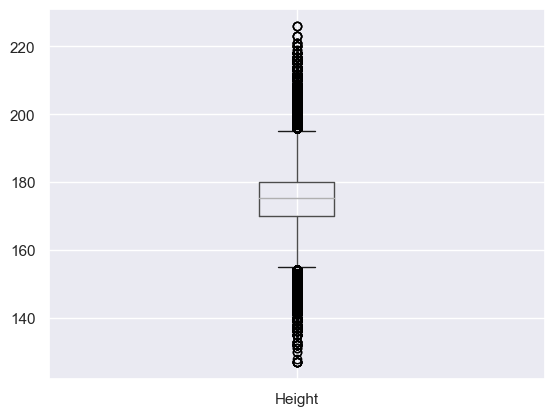

In [71]:
new_data.boxplot(column='Height',return_type='axes')

In [72]:
cols = ['Height']
low = .05
high = .95 #Return values at the given quantile  0.95 (95% quantile)
quant_data =  new_data[cols].quantile([low, high])
print(quant_data)

      Height
0.05   160.0
0.95   191.0


In [73]:
higher = quant_data.loc[high,'Height']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

new_data['Height'] = new_data['Height'].apply(func)

<Axes: >

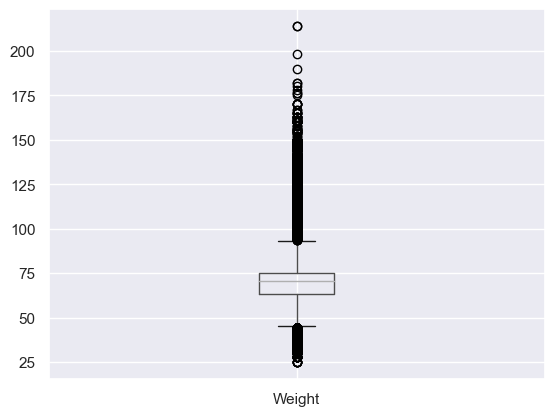

In [74]:
new_data.boxplot(column='Weight',return_type='axes')

In [75]:
cols = ['Weight']
low = .05
high = .95 #Return values at the given quantile  0.95 (95% quantile)
quant_data =  new_data[cols].quantile([low, high])
print(quant_data)

      Weight
0.05    52.0
0.95    93.0


In [76]:
higher = quant_data.loc[high,'Weight']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

new_data['Weight'] = new_data['Weight'].apply(func)

## Filtrage des données pour un échantillon moins conséquent

In [77]:
# Création d'un nouveau dataframe jeux d'été après traitement des valeurs manquantes
df_summer_2 = new_data[new_data['Season'] == 'Summer']
df_summer_2

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
0,1,A Dijiang,M,24.0,180.00000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NW,China,U
1,2,A Lamusi,M,23.0,170.00000,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NW,China,U
2,3,Gunnar Nielsen Aaby,M,24.0,175.33897,70.702393,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NW,Denmark,U
3,4,Edgar Lindenau Aabye,M,34.0,175.33897,70.702393,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,U
26,8,"Cornelia ""Cor"" Aalten (-Strannood)",F,18.0,168.00000,70.702393,Netherlands,NED,1932 Summer,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,NW,Netherlands,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271106,135565,Fernando scar Zylberberg,M,27.0,168.00000,76.000000,Argentina,ARG,2004 Summer,2004,Summer,Athina,Hockey,Hockey Men's Hockey,NW,Argentina,U
271107,135566,"James Francis ""Jim"" Zylker",M,21.0,175.00000,75.000000,United States,USA,1972 Summer,1972,Summer,Munich,Football,Football Men's Football,NW,USA,U
271108,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.00000,72.000000,Russia,RUS,2000 Summer,2000,Summer,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U
271109,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.00000,72.000000,Russia,RUS,2004 Summer,2004,Summer,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U


In [78]:
# Justification dans le compte-rendu
df_summer_2.loc[df_summer_2['Sport'] == 'Synchronized Swimming', 'Sport'] = 'Artistic Swimming'

In [79]:
# Répartition des athlètes par sexe pour les jeux d'été à nouveau après traitement des valeurs manquantes
sex_summer_2 = df_summer_2.groupby(['Sex','Year']).size().reset_index().pivot(columns='Sex', index='Year', values=0).reset_index()
sex_summer_2

Sex,Year,F,M
0,1896,NaN,380.0
1,1900,33.0,1903.0
2,1904,16.0,1285.0
3,1906,11.0,1722.0
4,1908,47.0,3054.0
5,1912,87.0,3953.0
6,1920,134.0,4158.0
7,1924,244.0,4989.0
8,1928,404.0,4588.0
9,1932,347.0,2622.0


In [80]:
# Calcul du pourcentage de femmes par rapport au total par année pour choix des jeux de l'échantillon
sex_summer_2['Pourcentage Femmes'] = (sex_summer_2['F'] / (sex_summer_2['F'] + sex_summer_2['M'])) * 100
sex_summer_2 = sex_summer_2.sort_values(by='Pourcentage Femmes', ascending=False)
sex_summer_2.head(10)

Sex,Year,F,M,Pourcentage Femmes
28,2016,6223.0,7465.0,45.463179
27,2012,5815.0,7105.0,45.007740
26,2008,5816.0,7786.0,42.758418
25,2004,5546.0,7897.0,41.255672
24,2000,5431.0,8390.0,39.295275
23,1996,5008.0,8772.0,36.342525
22,1992,4124.0,8853.0,31.779302
21,1988,3543.0,8494.0,29.434244
20,1984,2447.0,7007.0,25.883224
18,1976,2172.0,6469.0,25.135980


In [81]:
# Sélectionn des JO d'été récents
filtered_data = df_summer_2[df_summer_2['Year'] >= 2000]

# Sélection des sports au programme des JO de Paris 2024 (source : https://olympics.com/en/paris-2024/sports)
sports_paris_2024 = ['Archery', 'Artistic Gymnastics', 'Artistic Swimming', 'Athletics', 'Badminton', 'Basketball', '3x3 Basketball', 'Beach Volleyball', 'Boxing', 'Breaking', 'Canoeing', 'Cycling', 'Diving', 'Equestrianism', 'Fencing', 'Football', 'Golf', 'Handball', 'Hockey', 'Judo', 'Marathon Swimming', 'Modern Pentathlon', 'Rhythmic Gymnastics', 'Rowing', 'Rugby Sevens', 'Sailing', 'Shooting', 'Skateboarding', 'Sport Climbing', 'Surfing', 'Swimming', 'Table Tennis', 'Taekwondo', 'Tennis', 'Trampolining', 'Triathlon', 'Volleyball', 'Water Polo', 'Weightlifting', 'Wrestling']
filtered_data = filtered_data[filtered_data['Sport'].isin(sports_paris_2024)]

filtered_data

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,region,notes
1,2,A Lamusi,M,23.0,170.0,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NW,China,U
31,12,Jyri Tapani Aalto,M,31.0,172.0,70.000000,Finland,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,NW,Finland,U
33,13,Minna Maarit Aalto,F,34.0,159.0,55.500000,Finland,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,NW,Finland,U
57,18,Timo Antero Aaltonen,M,31.0,189.0,93.000000,Finland,FIN,2000 Summer,2000,Summer,Sydney,Athletics,Athletics Men's Shot Put,NW,Finland,U
79,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,70.702393,Norway,NOR,2008 Summer,2008,Summer,Beijing,Handball,Handball Women's Handball,Gold,Norway,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271105,135565,Fernando scar Zylberberg,M,23.0,168.0,76.000000,Argentina,ARG,2000 Summer,2000,Summer,Sydney,Hockey,Hockey Men's Hockey,NW,Argentina,U
271106,135565,Fernando scar Zylberberg,M,27.0,168.0,76.000000,Argentina,ARG,2004 Summer,2004,Summer,Athina,Hockey,Hockey Men's Hockey,NW,Argentina,U
271108,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.000000,Russia,RUS,2000 Summer,2000,Summer,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U
271109,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.000000,Russia,RUS,2004 Summer,2004,Summer,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U


In [82]:
filtered_data.isnull().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
region    0
notes     0
dtype: int64

In [83]:
len(sports_paris_2024)

40

In [84]:
len(filtered_data['Sport'].unique())

33

In [85]:
set1 = set(sports_paris_2024)
set2 = set(filtered_data['Sport'].unique())
difference = set1 - set2
difference

{'3x3 Basketball',
 'Artistic Gymnastics',
 'Breaking',
 'Marathon Swimming',
 'Skateboarding',
 'Sport Climbing',
 'Surfing'}

L'explication de la prise en compte des sports manquants se trouve dans la section "Nos épreuves" du compte-rendu.

In [86]:
hosting_countries = {
    2000: 'Australia',
    2004: 'Greece',
    2008: 'China',
    2012: 'United Kingdom',
    2016: 'Brazil'
}

# Ajouter de la colonne "Hosting Country" en utilisant le dictionnaire
filtered_data['Hosting Country'] = filtered_data['Year'].map(hosting_countries)

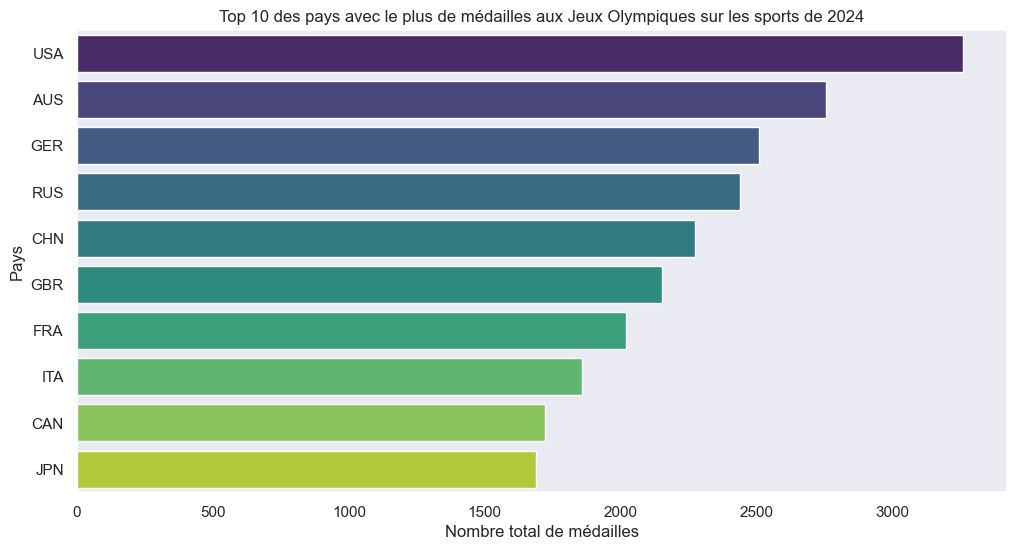

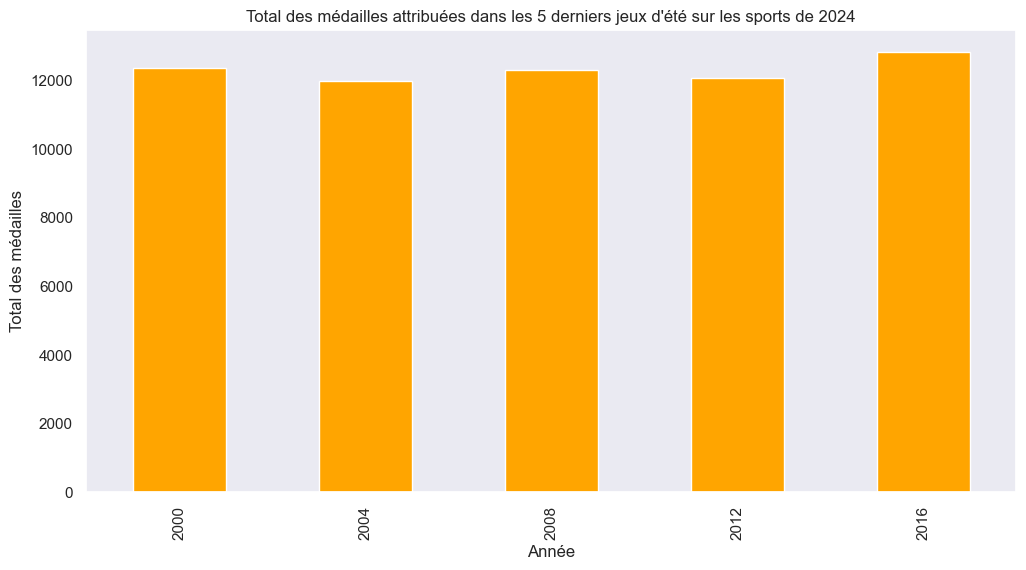

In [87]:
# Distribution des médailles par pays selon les sports présents aux JO en 2024
plt.figure(figsize=(12, 6))
top_countries = filtered_data.groupby('NOC')['Medal'].count().sort_values(ascending=False).head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.xlabel('Nombre total de médailles')
plt.ylabel('Pays')
plt.title('Top 10 des pays avec le plus de médailles aux Jeux Olympiques sur les sports de 2024')
plt.show()

# Total des médailles par année depuis 2000
plt.figure(figsize=(12, 6))
total_medals_per_year = filtered_data.groupby('Year')['Medal'].count()
total_medals_per_year.plot(kind='bar', color='orange')
plt.xlabel('Année')
plt.ylabel('Total des médailles')
plt.title('Total des médailles attribuées dans les 5 derniers jeux d\'été sur les sports de 2024')
plt.show()

### Feature engineering

In [88]:
GDP = pd.read_csv('data/countries.csv')
GDP

,Rank,ID,Country,Continent,Population,IMF_GDP,UN_GDP,GDP_per_capita
0,1,840,United States,North America,339996.56,2.669515e+13,1.862448e+13,78515.94
1,2,156,China,Asia,1425671.35,2.186548e+13,1.121828e+13,15336.97
2,3,392,Japan,Asia,123294.51,5.291351e+12,4.936212e+12,42916.35
3,4,276,Germany,Europe,83294.63,4.564778e+12,3.477796e+12,54802.79
4,5,356,India,Asia,1428627.66,3.893670e+12,2.259642e+12,2725.46
...,...,...,...,...,...,...,...,...
207,208,729,Sudan,Africa,48109.01,0.000000e+00,8.288740e+10,1722.91
208,209,760,Syria,Asia,23227.01,0.000000e+00,2.216308e+10,954.19
209,210,788,Tunisia,Africa,12458.22,0.000000e+00,4.170356e+10,3347.47
210,211,796,Turks and Caicos Islands,North America,46.06,0.000000e+00,9.175505e+08,19919.90


In [89]:
olympics_merge_gdp = pd.merge(filtered_data, GDP, left_on='Team', right_on='Country', how='left')
olympics_merge_gdp

,ID_x,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,notes,Hosting Country,Rank,ID_y,Country,Continent,Population,IMF_GDP,UN_GDP,GDP_per_capita
0,2,A Lamusi,M,23.0,170.0,60.000000,China,CHN,2012 Summer,2012,...,U,United Kingdom,2.0,156.0,China,Asia,1425671.35,2.186548e+13,1.121828e+13,15336.97
1,12,Jyri Tapani Aalto,M,31.0,172.0,70.000000,Finland,FIN,2000 Summer,2000,...,U,Australia,46.0,246.0,Finland,Europe,5545.48,3.145020e+11,2.385029e+11,56713.27
2,13,Minna Maarit Aalto,F,34.0,159.0,55.500000,Finland,FIN,2000 Summer,2000,...,U,Australia,46.0,246.0,Finland,Europe,5545.48,3.145020e+11,2.385029e+11,56713.27
3,18,Timo Antero Aaltonen,M,31.0,189.0,93.000000,Finland,FIN,2000 Summer,2000,...,U,Australia,46.0,246.0,Finland,Europe,5545.48,3.145020e+11,2.385029e+11,56713.27
4,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,70.702393,Norway,NOR,2008 Summer,2008,...,U,China,30.0,578.0,Norway,Europe,5474.36,5.497330e+11,3.710689e+11,100419.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61537,135565,Fernando scar Zylberberg,M,23.0,168.0,76.000000,Argentina,ARG,2000 Summer,2000,...,U,Australia,27.0,32.0,Argentina,South America,45773.88,5.736330e+11,5.458662e+11,12531.88
61538,135565,Fernando scar Zylberberg,M,27.0,168.0,76.000000,Argentina,ARG,2004 Summer,2004,...,U,Greece,27.0,32.0,Argentina,South America,45773.88,5.736330e+11,5.458662e+11,12531.88
61539,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.000000,Russia,RUS,2000 Summer,2000,...,U,Australia,14.0,643.0,Russia,Europe,144444.36,1.713154e+12,1.246015e+12,11860.30
61540,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.000000,Russia,RUS,2004 Summer,2004,...,U,Greece,14.0,643.0,Russia,Europe,144444.36,1.713154e+12,1.246015e+12,11860.30


In [90]:
olympics_merge_gdp.drop(['ID_y', 'Country', 'Continent','IMF_GDP', 'UN_GDP'], axis=1, inplace=True)

In [91]:
olympics_merge_gdp

,ID_x,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,City,Sport,Event,Medal,region,notes,Hosting Country,Rank,Population,GDP_per_capita
0,2,A Lamusi,M,23.0,170.0,60.000000,China,CHN,2012 Summer,2012,...,London,Judo,Judo Men's Extra-Lightweight,NW,China,U,United Kingdom,2.0,1425671.35,15336.97
1,12,Jyri Tapani Aalto,M,31.0,172.0,70.000000,Finland,FIN,2000 Summer,2000,...,Sydney,Badminton,Badminton Men's Singles,NW,Finland,U,Australia,46.0,5545.48,56713.27
2,13,Minna Maarit Aalto,F,34.0,159.0,55.500000,Finland,FIN,2000 Summer,2000,...,Sydney,Sailing,Sailing Women's Windsurfer,NW,Finland,U,Australia,46.0,5545.48,56713.27
3,18,Timo Antero Aaltonen,M,31.0,189.0,93.000000,Finland,FIN,2000 Summer,2000,...,Sydney,Athletics,Athletics Men's Shot Put,NW,Finland,U,Australia,46.0,5545.48,56713.27
4,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,70.702393,Norway,NOR,2008 Summer,2008,...,Beijing,Handball,Handball Women's Handball,Gold,Norway,U,China,30.0,5474.36,100419.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61537,135565,Fernando scar Zylberberg,M,23.0,168.0,76.000000,Argentina,ARG,2000 Summer,2000,...,Sydney,Hockey,Hockey Men's Hockey,NW,Argentina,U,Australia,27.0,45773.88,12531.88
61538,135565,Fernando scar Zylberberg,M,27.0,168.0,76.000000,Argentina,ARG,2004 Summer,2004,...,Athina,Hockey,Hockey Men's Hockey,NW,Argentina,U,Greece,27.0,45773.88,12531.88
61539,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.000000,Russia,RUS,2000 Summer,2000,...,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U,Australia,14.0,144444.36,11860.30
61540,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.000000,Russia,RUS,2004 Summer,2004,...,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U,Greece,14.0,144444.36,11860.30


## Encodage

In [92]:
olympics_merge_gdp['Medal'].unique()

array(['NW', 'Gold', 'Bronze', 'Silver'], dtype=object)

In [93]:
medal_categories = ['NW', 'Bronze', 'Silver', 'Gold']

encoder = OrdinalEncoder(categories=[medal_categories])

olympics_merge_gdp[['medal_enc']] = encoder.fit_transform(olympics_merge_gdp[['Medal']])

olympics_merge_gdp

,ID_x,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,region,notes,Hosting Country,Rank,Population,GDP_per_capita,medal_enc
0,2,A Lamusi,M,23.0,170.0,60.000000,China,CHN,2012 Summer,2012,...,Judo,Judo Men's Extra-Lightweight,NW,China,U,United Kingdom,2.0,1425671.35,15336.97,0.0
1,12,Jyri Tapani Aalto,M,31.0,172.0,70.000000,Finland,FIN,2000 Summer,2000,...,Badminton,Badminton Men's Singles,NW,Finland,U,Australia,46.0,5545.48,56713.27,0.0
2,13,Minna Maarit Aalto,F,34.0,159.0,55.500000,Finland,FIN,2000 Summer,2000,...,Sailing,Sailing Women's Windsurfer,NW,Finland,U,Australia,46.0,5545.48,56713.27,0.0
3,18,Timo Antero Aaltonen,M,31.0,189.0,93.000000,Finland,FIN,2000 Summer,2000,...,Athletics,Athletics Men's Shot Put,NW,Finland,U,Australia,46.0,5545.48,56713.27,0.0
4,21,Ragnhild Margrethe Aamodt,F,27.0,163.0,70.702393,Norway,NOR,2008 Summer,2008,...,Handball,Handball Women's Handball,Gold,Norway,U,China,30.0,5474.36,100419.59,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61537,135565,Fernando scar Zylberberg,M,23.0,168.0,76.000000,Argentina,ARG,2000 Summer,2000,...,Hockey,Hockey Men's Hockey,NW,Argentina,U,Australia,27.0,45773.88,12531.88,0.0
61538,135565,Fernando scar Zylberberg,M,27.0,168.0,76.000000,Argentina,ARG,2004 Summer,2004,...,Hockey,Hockey Men's Hockey,NW,Argentina,U,Greece,27.0,45773.88,12531.88,0.0
61539,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.000000,Russia,RUS,2000 Summer,2000,...,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U,Australia,14.0,144444.36,11860.30,0.0
61540,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.000000,Russia,RUS,2004 Summer,2004,...,Rowing,Rowing Men's Lightweight Coxless Fours,NW,Russia,U,Greece,14.0,144444.36,11860.30,0.0


In [94]:
olympics_merge_gdp.isna().sum()

ID_x                  0
Name                  0
Sex                   0
Age                   0
Height                0
Weight                0
Team                  0
NOC                   0
Games                 0
Year                  0
Season                0
City                  0
Sport                 0
Event                 0
Medal                 0
region                0
notes                 0
Hosting Country       0
Rank               4020
Population         4020
GDP_per_capita     4020
medal_enc             0
dtype: int64

In [95]:
olympics_merge_gdp[olympics_merge_gdp['GDP_per_capita'].isnull()]

,ID_x,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,region,notes,Hosting Country,Rank,Population,GDP_per_capita,medal_enc
233,432,Koutoua Francis Abia,M,42.0,180.0,80.0,Cote d'Ivoire,CIV,2008 Summer,2008,...,Canoeing,"Canoeing Men's Kayak Singles, 500 metres",NW,Ivory Coast,U,China,NaN,NaN,NaN,0.0
234,432,Koutoua Francis Abia,M,42.0,180.0,80.0,Cote d'Ivoire,CIV,2008 Summer,2008,...,Canoeing,"Canoeing Men's Kayak Singles, 1,000 metres",NW,Ivory Coast,U,China,NaN,NaN,NaN,0.0
344,664,Kieron Robert Achara,M,29.0,191.0,93.0,Great Britain,GBR,2012 Summer,2012,...,Basketball,Basketball Men's Basketball,NW,UK,U,United Kingdom,NaN,NaN,NaN,0.0
347,675,"Onochie Lawrence ""Larry"" Achike",M,25.0,188.0,75.0,Great Britain,GBR,2000 Summer,2000,...,Athletics,Athletics Men's Triple Jump,NW,UK,U,Australia,NaN,NaN,NaN,0.0
348,675,"Onochie Lawrence ""Larry"" Achike",M,33.0,188.0,75.0,Great Britain,GBR,2008 Summer,2008,...,Athletics,Athletics Men's Triple Jump,NW,UK,U,China,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61365,135244,Dragan Zori,M,25.0,191.0,92.0,Serbia and Montenegro,SCG,2004 Summer,2004,...,Canoeing,"Canoeing Men's Kayak Doubles, 1,000 metres",NW,Serbia,Serbia and Montenegro,Greece,NaN,NaN,NaN,0.0
61369,135246,Stevan Zori,M,29.0,191.0,75.0,Serbia and Montenegro,SCG,2000 Summer,2000,...,Athletics,Athletics Men's High Jump,NW,Serbia,Serbia and Montenegro,Australia,NaN,NaN,NaN,0.0
61407,135322,Nathalie Xenia Margareta Benedikte zu Sayn-Wit...,F,33.0,176.0,85.0,Digby,DEN,2008 Summer,2008,...,Equestrianism,"Equestrianism Mixed Dressage, Team",Bronze,Denmark,U,China,NaN,NaN,NaN,1.0
61465,135424,Nadine Zumkehr,F,31.0,172.0,64.0,Switzerland-1,SUI,2016 Summer,2016,...,Beach Volleyball,Beach Volleyball Women's Beach Volleyball,NW,Switzerland,U,Brazil,NaN,NaN,NaN,0.0


In [96]:
olympics_merge_gdp[olympics_merge_gdp['Team'] == 'Serbia']

,ID_x,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Sport,Event,Medal,region,notes,Hosting Country,Rank,Population,GDP_per_capita,medal_enc
1275,2516,Aleksandar Aleksi,M,20.0,188.0,89.0,Serbia,SRB,2012 Summer,2012,...,Canoeing,"Canoeing Men's Kayak Fours, 1,000 metres",NW,Serbia,U,United Kingdom,81.0,7149.08,10153.34,0.0
1276,2517,Milan Aleksi,M,26.0,191.0,93.0,Serbia,SRB,2012 Summer,2012,...,Water Polo,Water Polo Men's Water Polo,Bronze,Serbia,U,United Kingdom,81.0,7149.08,10153.34,1.0
1277,2517,Milan Aleksi,M,30.0,191.0,93.0,Serbia,SRB,2016 Summer,2016,...,Water Polo,Water Polo Men's Water Polo,Gold,Serbia,U,Brazil,81.0,7149.08,10153.34,3.0
2487,5346,Andrea Arsovi,F,25.0,165.0,61.0,Serbia,SRB,2012 Summer,2012,...,Shooting,"Shooting Women's Air Rifle, 10 metres",NW,Serbia,U,United Kingdom,81.0,7149.08,10153.34,0.0
2488,5346,Andrea Arsovi,F,25.0,165.0,61.0,Serbia,SRB,2012 Summer,2012,...,Shooting,"Shooting Women's Small-Bore Rifle, Three Posit...",NW,Serbia,U,United Kingdom,81.0,7149.08,10153.34,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61337,135156,Andrija Zlati,M,34.0,178.0,75.0,Serbia,SRB,2012 Summer,2012,...,Shooting,"Shooting Men's Air Pistol, 10 metres",Bronze,Serbia,U,United Kingdom,81.0,7149.08,10153.34,1.0
61338,135156,Andrija Zlati,M,34.0,178.0,75.0,Serbia,SRB,2012 Summer,2012,...,Shooting,"Shooting Men's Free Pistol, 50 metres",NW,Serbia,U,United Kingdom,81.0,7149.08,10153.34,0.0
61366,135245,Milenko Zori,M,23.0,179.0,73.0,Serbia,SRB,2012 Summer,2012,...,Canoeing,"Canoeing Men's Kayak Fours, 1,000 metres",NW,Serbia,U,United Kingdom,81.0,7149.08,10153.34,0.0
61367,135245,Milenko Zori,M,27.0,179.0,73.0,Serbia,SRB,2016 Summer,2016,...,Canoeing,"Canoeing Men's Kayak Doubles, 1,000 metres",Silver,Serbia,U,Brazil,81.0,7149.08,10153.34,2.0


Nous avons des données manquantes dans la colonne du PIB par habitant cependant ce n'est pas un problème car d'après les tests certains pays affichent des valeurs nulles dans la colonne du PIB mais nous avons quand même les données de ces pays comme l'exemple pris au dessus avec la Serbie qui fait partie des pays avec un GDP nul, mais il s'agit de certains athlètes pour qui la donnée n'est pas renseignée.
Nous pouvons donc drop les valeurs nulles de GDP.

In [97]:
olympics_merge_gdp.dropna(subset=['GDP_per_capita'], inplace=True)

In [98]:
sex_encoder = preprocessing.LabelEncoder()
olympics_merge_gdp['encoded_sex'] = sex_encoder.fit_transform(olympics_merge_gdp['Sex'])

In [99]:
ordinal_encoder = preprocessing.OrdinalEncoder() # Attributs ordinaux

olympics_merge_gdp[['Age', 'Height','Weight']] = ordinal_encoder.fit_transform(olympics_merge_gdp[['Age', 'Height','Weight']])

In [100]:
#feature_names = ['encoded_sex','Age', 'Height', 'Weight', 'Population','GDP_per_capita']
#X_DF = olympics_merge_gdp[feature_names]
#y_DF = olympics_merge_gdp['medal_enc']

## Modifications additionnelles après essais infructueux

Pour réduire la mémoire à allouer dans les modèles (nos tentatives de modélisation ne fonctionne pas pour cette raison, nous réduisons la taille du dataframe utilisé en regroupant les athlètes par pays)

In [101]:
# Compte médailles sans distinction
olympics_merge_gdp['Médailles'] = olympics_merge_gdp['Medal'].replace(['NW'], 0)
olympics_merge_gdp['Médailles'] = olympics_merge_gdp['Médailles'].replace(['Bronze', 'Silver', 'Gold'], 1)

In [102]:
# Supprimer les redondances de médailles pour les sports collectifs
df_medal = olympics_merge_gdp.drop_duplicates(subset=['Event', 'region', 'Year', 'Medal'])
df_medal

,ID_x,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,...,Medal,region,notes,Hosting Country,Rank,Population,GDP_per_capita,medal_enc,encoded_sex,Médailles
0,2,A Lamusi,M,11.0,32.0,31.0,China,CHN,2012 Summer,2012,...,NW,China,U,United Kingdom,2.0,1425671.35,15336.97,0.0,1,0
1,12,Jyri Tapani Aalto,M,20.0,34.0,50.0,Finland,FIN,2000 Summer,2000,...,NW,Finland,U,Australia,46.0,5545.48,56713.27,0.0,1,0
2,13,Minna Maarit Aalto,F,23.0,21.0,25.0,Finland,FIN,2000 Summer,2000,...,NW,Finland,U,Australia,46.0,5545.48,56713.27,0.0,0,0
3,18,Timo Antero Aaltonen,M,20.0,52.0,91.0,Finland,FIN,2000 Summer,2000,...,NW,Finland,U,Australia,46.0,5545.48,56713.27,0.0,1,0
4,21,Ragnhild Margrethe Aamodt,F,16.0,25.0,52.0,Norway,NOR,2008 Summer,2008,...,Gold,Norway,U,China,30.0,5474.36,100419.59,3.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61523,135528,Marc Zwiebler,M,17.0,44.0,61.0,Germany,GER,2012 Summer,2012,...,NW,Germany,U,United Kingdom,4.0,83294.63,54802.79,0.0,1,0
61524,135528,Marc Zwiebler,M,21.0,44.0,61.0,Germany,GER,2016 Summer,2016,...,NW,Germany,U,Brazil,4.0,83294.63,54802.79,0.0,1,0
61526,135535,Claudia Antoinette Zwiers,F,19.0,44.0,67.0,Netherlands,NED,2004 Summer,2004,...,NW,Netherlands,U,Greece,18.0,17618.30,60890.61,0.0,0,0
61527,135547,Viktoriya Viktorovna Zyabkina,F,7.0,36.0,35.0,Kazakhstan,KAZ,2012 Summer,2012,...,NW,Kazakhstan,U,United Kingdom,54.0,19606.63,11523.04,0.0,0,0


Cette partie du code est asujettie à modification si nous voulons des résultats où le poids des médailles est pris en compte

In [103]:
# medal_enc en paramètre pour prendre en compte le poids des médailles | Médailles en paramètre pour ne compter que le nombre de médailles au total
count_medals = df_medal.groupby(['region', 'Year']).agg({'Médailles': 'sum'}).reset_index()

In [104]:
df_athletes = olympics_merge_gdp.groupby(['region', 'Year', 'Hosting Country','GDP_per_capita']).size().reset_index(name='Nombre d\'athlètes')

In [105]:
df_final = pd.merge(df_athletes, count_medals, on=['region', 'Year'], how='inner')

In [106]:
lisibilité = {'region': 'Pays', 'Year': 'Année', 'Hosting Country': 'Lieu', 'GDP_per_capita': 'PIB'}
df_final.rename(columns=lisibilité, inplace=True)

In [107]:
# Pays hôte des jeux
df_final['Organisateur'] = df_final.apply(lambda row: 1 if row['Lieu'] == row['Pays'] else 0, axis=1)

In [108]:
orga = df_final[df_final['Organisateur'] == True]
orga

,Pays,Année,Lieu,PIB,Nombre d'athlètes,Médailles,Organisateur
44,Australia,2000,Australia,69154.90,677,56,1
128,Brazil,2016,Brazil,9151.01,525,14,1
192,China,2008,China,15336.97,607,79,1
193,China,2008,China,52236.84,47,79,1
333,Greece,2004,Greece,22705.90,439,15,1


In [109]:
# Gestion des doublons
df_final = df_final.drop_duplicates(subset=['Pays', 'Année'])

In [110]:
orga = df_final[df_final['Organisateur'] == True]
orga

,Pays,Année,Lieu,PIB,Nombre d'athlètes,Médailles,Organisateur
44,Australia,2000,Australia,69154.90,677,56,1
128,Brazil,2016,Brazil,9151.01,525,14,1
192,China,2008,China,15336.97,607,79,1
333,Greece,2004,Greece,22705.90,439,15,1


In [111]:
df_final

,Pays,Année,Lieu,PIB,Nombre d'athlètes,Médailles,Organisateur
0,Afghanistan,2004,Greece,479.05,5,0,0
1,Afghanistan,2008,China,479.05,4,1,0
2,Afghanistan,2012,United Kingdom,479.05,6,1,0
3,Afghanistan,2016,Brazil,479.05,3,0,0
4,Albania,2000,Australia,6729.89,5,0,0
...,...,...,...,...,...,...,...
939,Zimbabwe,2000,Australia,2079.40,26,0,0
940,Zimbabwe,2004,Greece,2079.40,14,3,0
941,Zimbabwe,2008,China,2079.40,16,4,0
942,Zimbabwe,2012,United Kingdom,2079.40,9,0,0


## Essai de modélisation avec Random Forest (tableau vide en résultat)

In [112]:
feature_name = ['PIB', 'Année','Nombre d\'athlètes','Organisateur']
# X_TRAIN
X_DF = df_final[feature_name]
# Y_TRAIN --> target, variable à prédire
y_DF = df_final['Médailles']

# Entraînement du modèle (n_estimators : The number of trees in the forest.)
forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1) # n_jobs=-1 signifie autant de jobs que de coeurs de processeur  
forest.fit(X_DF, y_DF)

RandomForestClassifier(n_estimators=1000, n_jobs=-1)

Importance des attributs d'entrée dans la prédiction "survived":  [0.32133009 0.11998249 0.55514763 0.0035398 ]


Text(0.5, 1.0, 'Importance des attributs')

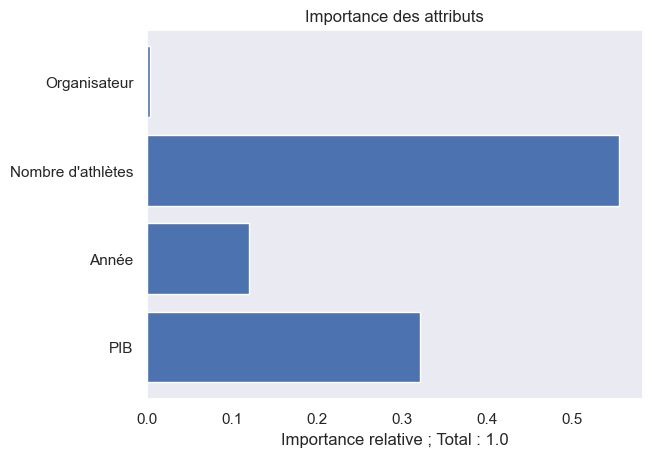

In [113]:
importance = forest.feature_importances_
print("Importance des attributs d'entrée dans la prédiction \"survived\": ", importance)

plt.barh(range(len(feature_name)), importance, align='center', tick_label=feature_name)
plt.xlabel('Importance relative ; Total : 1.0')
plt.title('Importance des attributs')

Les critères différenciant semblent être le nombre d'athlètes suivi du PIB

In [114]:
# trop long à exécuter
#model = RandomForestClassifier(n_jobs=4) 

#params = { 
#    "n_estimators": [100, 200, 400, 800], #nombre d’arbres à entraîner
#    "max_features":  [1, 2, 3, 4], #nombre max. d'attributs qu’on tire aléatoirement pour chaque arbre
#    "max_depth": [3, 4, 5, 6], #profondeur maximale de chaque arbre
#    "min_samples_split": [2, 4, 7, 10], #nombre minimum d’observations pour créer des sous-nœuds
#    "min_samples_leaf": [1, 2, 3], #The minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. 
#    "criterion": ["gini", "entropy"] #critère statistique utilisé pour couper les feuilles : 'gini' ou 'entropy'
#}

#gs = GridSearchCV(estimator=model, param_grid=params, verbose=1, scoring='roc_auc', cv=3)# verbose à 3 pour voir les tests différents / à 1 pour peu de détails
#gs.fit(X_DF, y_DF)
#print(gs.best_params_)

In [115]:
model = RandomForestClassifier(n_jobs=4) 

params = { 
    "n_estimators": [100, 200, 400, 800],
}

gs = GridSearchCV(estimator=model, param_grid=params, verbose=3, scoring='roc_auc', cv=3)
gs.fit(X_DF, y_DF)
print(gs.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 45

[CV 1/3] END ....................n_estimators=100;, score=nan total time=   2.6s
[CV 2/3] END ....................n_estimators=100;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END ....................n_estimators=100;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END ....................n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END ....................n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END ....................n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END ....................n_estimators=400;, score=nan total time=   0.5s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END ....................n_estimators=400;, score=nan total time=   0.6s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END ....................n_estimators=400;, score=nan total time=   0.5s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END ....................n_estimators=800;, score=nan total time=   1.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END ....................n_estimators=800;, score=nan total time=   1.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklear

[CV 3/3] END ....................n_estimators=800;, score=nan total time=   1.2s
{'n_estimators': 100}


In [116]:
model = RandomForestClassifier(n_jobs=-1) 

params = { 
    "n_estimators": [200],
    "max_features":  [1, 2, 3, 4]
}

gs = GridSearchCV(estimator=model, param_grid=params, verbose=3, scoring='roc_auc', cv=3)
gs.fit(X_DF, y_DF)
print(gs.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 45

[CV 1/3] END ....max_features=1, n_estimators=200;, score=nan total time=   4.5s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END ....max_features=1, n_estimators=200;, score=nan total time=   0.3s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END ....max_features=1, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END ....max_features=2, n_estimators=200;, score=nan total time=   0.3s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END ....max_features=2, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END ....max_features=2, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END ....max_features=3, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END ....max_features=3, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END ....max_features=3, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END ....max_features=4, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END ....max_features=4, n_estimators=200;, score=nan total time=   0.2s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklear

[CV 3/3] END ....max_features=4, n_estimators=200;, score=nan total time=   0.2s
{'max_features': 1, 'n_estimators': 200}


In [117]:
model = RandomForestClassifier(n_jobs=-1) 

params = { 
    "n_estimators": [200],
    "max_features":  [2],
    "max_depth": [2, 4, 6, 8]
}

gs = GridSearchCV(estimator=model, param_grid=params, verbose=3, scoring='roc_auc', cv=3)
gs.fit(X_DF, y_DF)
print(gs.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 45

[CV 1/3] END max_depth=2, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END max_depth=2, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END max_depth=2, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END max_depth=4, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END max_depth=4, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END max_depth=4, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END max_depth=6, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END max_depth=6, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 3/3] END max_depth=6, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 1/3] END max_depth=8, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


[CV 2/3] END max_depth=8, max_features=2, n_estimators=200;, score=nan total time=   0.1s


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 452, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklear

[CV 3/3] END max_depth=8, max_features=2, n_estimators=200;, score=nan total time=   0.1s
{'max_depth': 2, 'max_features': 2, 'n_estimators': 200}


In [118]:
model = RandomForestClassifier(n_jobs=4) 

params = { 
    "n_estimators": [100, 200, 400, 800],
    "max_features":  [1, 2, 3, 4],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [2, 3, 5, 7, 9, 11],
    "min_samples_leaf": [1, 2, 3],
    "criterion": ["gini", "entropy"]
}

rs = RandomizedSearchCV(estimator=model, param_distributions=params, verbose=1, scoring='roc_auc', cv=3) # verbose à 3 pour les détails
rs.fit(X_DF, y_DF)
print(f"Best Params: {rs.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 45

Best Params: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 4, 'max_depth': 7, 'criterion': 'gini'}


Ici la meilleure combinaison pour les paramètre est :  
- 'n_estimators': 800
- 'min_samples_split': 9
- 'min_samples_leaf': 2
- 'max_features': 3
- 'max_depth': 3
- 'criterion': 'entropy'}

In [119]:
X = df_final.drop(['Médailles'], axis=1)
y = df_final['Médailles']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Entraînement du modèle (n_estimators : The number of trees in the forest.)
forest = RandomForestClassifier(n_estimators=800, 
                                n_jobs=-1, 
                                min_samples_split=9, 
                                min_samples_leaf=2, 
                                max_features=3, 
                                max_depth=3, 
                                criterion='entropy')
forest.fit(X_DF, y_DF)

RandomForestClassifier(criterion='entropy', max_depth=3, max_features=3,
                       min_samples_leaf=2, min_samples_split=9,
                       n_estimators=800, n_jobs=-1)

In [120]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 939 entries, 0 to 943
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pays               939 non-null    object 
 1   Année              939 non-null    int64  
 2   Lieu               939 non-null    object 
 3   PIB                939 non-null    float64
 4   Nombre d'athlètes  939 non-null    int64  
 5   Organisateur       939 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 51.4+ KB


In [121]:
X.columns.tolist()

['Pays', 'Année', 'Lieu', 'PIB', "Nombre d'athlètes", 'Organisateur']

In [122]:
X.head()

,Pays,Année,Lieu,PIB,Nombre d'athlètes,Organisateur
0,Afghanistan,2004,Greece,479.05,5,0
1,Afghanistan,2008,China,479.05,4,0
2,Afghanistan,2012,United Kingdom,479.05,6,0
3,Afghanistan,2016,Brazil,479.05,3,0
4,Albania,2000,Australia,6729.89,5,0


In [123]:
numeric_cols = ['Année', 'PIB', 'Nombre d\'athlètes', 'Organisateur']
categorical_cols = ['Pays', 'Lieu']
removed_cols = []

numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_cols),
    ( categorical_transformer, categorical_cols), 
    ('drop', removed_cols)
)
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier())
])
pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5612903225806452


In [124]:
from sklearn.model_selection import GridSearchCV

params={
    'clf__n_estimators':[100, 200, 500],
    'clf__max_depth': [5, 6, 7, 8], 
    'clf__min_samples_leaf': [2, 6, 10]
}

grid_pipe = GridSearchCV(pipe,
                         param_grid=params,
                         cv=5,
                         verbose=1)

grid_pipe.fit(X_train, y_train)
print(grid_pipe.best_params_)
print(grid_pipe.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


{'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 100}
0.5993650793650793


In [125]:
numeric_cols = ['Année', 'PIB', 'Nombre d\'athlètes', 'Organisateur']
categorical_cols = ['Pays', 'Lieu']
removed_cols = []

numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_cols),
    ( categorical_transformer, categorical_cols), 
    ('drop', removed_cols)
)

best_params={
    'n_estimators':[100],
    'max_depth': [58], 
    'min_samples_leaf': [2]
}

pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200,max_depth=7,min_samples_leaf=2))
])
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Année', 'PIB',
                                                   "Nombre d'athlètes",
                                                   'Organisateur']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pays', 'Lieu']),
                                                 ('drop', 'drop', [])])),
                ('clf',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=2,
                                        n_estimators=200))])

In [126]:
pipe.fit(X_train, y_train);
y_pred = pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5419354838709678


In [127]:
submission = pd.DataFrame({
    "Pays": X_test['Pays'],
    "Médailles": y_pred
})

submission.to_csv('pronostic.csv', index=False)

In [128]:
submission.head()

,Pays,Médailles
143,Burundi,0
253,Dominican Republic,0
303,France,0
168,Cayman Islands,0
798,Sri Lanka,0


## Evaluation et Optimisation

In [129]:
model = RandomForestClassifier(n_jobs=4) 

params = { 
    "n_estimators": [100, 200, 400, 800],
    "max_features":  [1, 2, 3, 4],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [2, 3, 5, 7, 9, 11],
    "min_samples_leaf": [1, 2, 3],
    "criterion": ["gini", "entropy"]
}

rs = RandomizedSearchCV(estimator=model, param_distributions=params, verbose=1, scoring='roc_auc', cv=3) # verbose à 3 pour les détails
rs.fit(X_DF, y_DF)
print(f"Best Params: {rs.best_params_}")

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\romai\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 45

Best Params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 3, 'max_depth': 3, 'criterion': 'entropy'}


Best Params: 
- 'n_estimators': 400
- 'min_samples_split': 5
- 'min_samples_leaf': 1
- 'max_features': 4
- 'max_depth': 4
- 'criterion': 'entropy'}

In [130]:
feature_names = ['PIB', 'Nombre d\'athlètes',  'Organisateur']
X_DF = df_final[feature_names]
y_DF = df_final['Médailles']

## Modélisation

In [131]:
X_trainDF, X_testDF, y_trainDF, y_testDF = train_test_split(X_DF, y_DF, test_size=.33)

In [132]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1) 

# Apprentissage sur 2/3 (train)
forest.fit(X=X_trainDF, y=y_trainDF)

# Evaluation : prédiction  sur l'autre 1/3 (test)
y_pred = forest.predict(X_testDF) 

accuracy = metrics.accuracy_score(y_testDF, y_pred)

print("\nExactitude  ", "%.3f" % accuracy)  # The best performance is 1


Exactitude   0.574


In [133]:
newForest = RandomForestClassifier(n_estimators=100, n_jobs=-1) 

# Evaluate a score by cross-validation 
scores = cross_val_score(newForest, X_DF, y_DF, cv=5)

scores

C:\Users\romai\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


array([0.59042553, 0.59574468, 0.52659574, 0.57446809, 0.57754011])

In [134]:
np.mean(scores)

0.5729548299010128

Ainsi nous pouvons conculure que la fiabilité du modèle n'est pas sensible à de nouvelle données. Les scores sont quasiment les mêmes.

Importance des attributs d'entrée dans la prédiction "medal":  [0.34341366 0.65038985 0.00619649]


Text(0.5, 1.0, 'Importance des attributs')

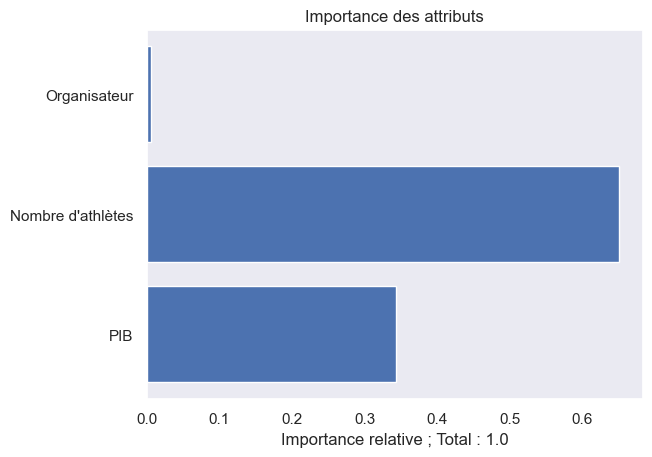

In [135]:
# Tracer un graphique de l'importance des attributs
%matplotlib inline

importance = forest.feature_importances_
print("Importance des attributs d'entrée dans la prédiction \"medal\": ", importance)

plt.barh(range(len(feature_names)), importance, align='center', tick_label=feature_names)
plt.xlabel('Importance relative ; Total : 1.0')
plt.title('Importance des attributs')

Conclusion :

le PIB et le nombre d'athlètes sont les arguments les plus importants

## Tentative non fructueuse

In [136]:
# Correction erreur Expected 2D array, got 1D array instead
sports_paris_2024_np = np.array(['Archery', 'Artistic Gymnastics', 'Artistic Swimming', 'Athletics', 'Badminton', 'Basketball', '3x3 Basketball', 'Beach Volleyball', 'Boxing', 'Breaking', 'Canoeing', 'Cycling', 'Diving', 'Equestrianism', 'Fencing', 'Football', 'Golf', 'Handball', 'Hockey', 'Judo', 'Marathon Swimming', 'Modern Pentathlon', 'Rhythmic Gymnastics', 'Rowing', 'Rugby Sevens', 'Sailing', 'Shooting', 'Skateboarding', 'Sport Climbing', 'Surfing', 'Swimming', 'Table Tennis', 'Taekwondo', 'Tennis', 'Trampolining', 'Triathlon', 'Volleyball', 'Water Polo', 'Weightlifting', 'Wrestling'])

sports_paris_2024_np = sports_paris_2024_np.reshape(-1, 1)

In [137]:
df_final

,Pays,Année,Lieu,PIB,Nombre d'athlètes,Médailles,Organisateur
0,Afghanistan,2004,Greece,479.05,5,0,0
1,Afghanistan,2008,China,479.05,4,1,0
2,Afghanistan,2012,United Kingdom,479.05,6,1,0
3,Afghanistan,2016,Brazil,479.05,3,0,0
4,Albania,2000,Australia,6729.89,5,0,0
...,...,...,...,...,...,...,...
939,Zimbabwe,2000,Australia,2079.40,26,0,0
940,Zimbabwe,2004,Greece,2079.40,14,3,0
941,Zimbabwe,2008,China,2079.40,16,4,0
942,Zimbabwe,2012,United Kingdom,2079.40,9,0,0


In [138]:
latest_year_data = df_final.loc[df_final.groupby('Pays')['Année'].idxmax()]

# Séparation des données en ensemble d'entraînement et de test
train_data, test_data = train_test_split(latest_year_data, test_size=0.2, random_state=42)

# Sélection des caractéristiques et de la cible
features = ['PIB', 'Nombre d\'athlètes']
target = 'Médailles'

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

# Créer et entraîner le modèle de régression linéaire
model = LinearRegression()
model.fit(X_train, y_train)

# Prédire les médailles pour 2024
predictions = model.predict(X_test)

# Évaluer les prédictions
mae = mean_absolute_error(y_test, predictions)
print(f"Erreur absolue moyenne (MAE) pour les prédictions 2024 : {mae}")

Erreur absolue moyenne (MAE) pour les prédictions 2024 : 2.259485560794615


In [139]:
latest_year_data = df_final.loc[df_final.groupby('Pays')['Année'].idxmax()]

features = ['PIB', 'Nombre d\'athlètes']
target = 'Médailles'

X_train = latest_year_data[features]
y_train = latest_year_data[target]

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Notre proposition de prédiction pour 2024 pour l'ensemble des pays participants

- source de la liste des pays : https://fr.wikipedia.org/wiki/Jeux_olympiques_d%27%C3%A9t%C3%A9_de_2024
- source du nombre d'athlètes : https://fr.wikipedia.org/wiki/Jeux_olympiques_d%27%C3%A9t%C3%A9_de_2020

In [140]:
import pandas as pd

# Création de la liste des noms de pays en anglais
countries = [
    'South Africa', 'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon', 'Cape Verde', 
    'Ivory Coast', 'Djibouti', 'Egypt', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 
    'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Morocco', 'Mauritius', 
    'Mauritania', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Uganda', 'Central African Republic', 
    'Democratic Republic of the Congo', 'Republic of the Congo', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 
    'Seychelles', 'Sierra Leone', 'Somalia', 'Sudan', 'South Sudan', 'Tanzania', 'Chad', 'Togo', 'Tunisia', 'Comoros', 
    'Zambia', 'Zimbabwe',
    'Argentina', 'Bolivia', 'Brazil', 'Canada', 'Colombia', 'Costa Rica', 'Cuba', 'Ecuador', 'United States', 
    'Guatemala', 'Jamaica', 'Mexico', 'Peru', 'Puerto Rico', 'Dominican Republic', 'Suriname', 'Trinidad and Tobago', 
    'Uruguay', 'Venezuela',
    'Afghanistan', 'Saudi Arabia', 'Bahrain', 'Bangladesh', 'Bhutan', 'Myanmar', 'Brunei', 'Cambodia', 'China', 
    'South Korea', 'United Arab Emirates', 'Hong Kong', 'India', 'Indonesia', 'Iraq', 'Iran', 'Israel', 'Japan', 
    'Jordan', 'Kazakhstan', 'Kyrgyzstan', 'Kuwait', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Nepal', 
    'Oman', 'Uzbekistan', 'Palestine', 'Pakistan', 'Philippines', 'Qatar', 'Singapore', 'Sri Lanka', 'Syria', 
    'Tajikistan', 'Taiwan', 'Thailand', 'Timor-Leste', 'Turkmenistan', 'Vietnam', 'Yemen', 'Albania', 'Germany', 
    'Andorra', 'Armenia', 'Austria', 'Azerbaijan', 'Belgium', 'Belarus', 'Bosnia and Herzegovina', 'Bulgaria', 
    'Cyprus', 'Croatia', 'Denmark', 'Estonia', 'Spain', 'Finland', 'France', 'Georgia', 'United Kingdom', 'Greece', 
    'Hungary', 'Ireland', 'Iceland', 'Italy', 'Kosovo', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 
    'North Macedonia', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Norway', 'Netherlands', 'Poland', 'Portugal', 
    'Russia', 'Romania', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Sweden', 'Switzerland', 'Czech Republic', 
    'Turkey', 'Ukraine', 'Australia', 'Fiji', 'Guam', 'Cook Islands', 'Kiribati', 'Marshall Islands', 'Micronesia', 
    'Nauru', 'New Zealand', 'Palau', 'Papua New Guinea', 'Solomon Islands', 'Samoa', 'American Samoa', 'Tonga', 
    'Tuvalu', 'Vanuatu'
]

# Créationd'un dictionnaire des chiffres correspondants aux pays
athletes = {
    'South Africa': 176, 'Algeria': 44, 'Angola': 20, 'Benin': 7, 'Botswana': 13, 'Burkina Faso': 7, 'Burundi': 6, 
    'Cameroon': 12, 'Cape Verde': 6, 'Ivory Coast': 27, 'Djibouti': 4, 'Egypt': 133, 'Eritrea': 13, 'Eswatini': 4, 
    'Ethiopia': 38, 'Gabon': 5, 'Gambia': 4, 'Ghana': 14, 'Guinea': 5, 'Guinea-Bissau': 4, 'Kenya': 85, 'Lesotho': 2, 
    'Liberia': 3, 'Libya': 4, 'Madagascar': 6, 'Malawi': 5, 'Mali': 4, 'Morocco': 50, 'Mauritius': 8, 'Mauritania': 2, 
    'Mozambique': 10, 'Namibia': 11, 'Niger': 7, 'Nigeria': 60, 'Uganda': 25, 'Central African Republic': 2, 
    'Democratic Republic of the Congo': 7, 'Republic of the Congo': 3, 'Rwanda': 6, 'Sao Tome and Principe': 3, 
    'Senegal': 9, 'Seychelles': 5, 'Sierra Leone': 4, 'Somalia': 2, 'Sudan': 5, 'South Sudan': 2, 'Tanzania': 3, 
    'Chad': 3, 'Togo': 4, 'Tunisia': 62, 'Comoros': 3, 'Zambia': 26, 'Zimbabwe': 5,
    'Argentina': 174, 'Bolivia': 4, 'Brazil': 301, 'Canada': 371, 'Colombia': 69, 'Costa Rica': 12, 'Cuba': 69, 
    'Ecuador': 47, 'United States': 620, 'Guatemala': 23, 'Jamaica': 58, 'Mexico': 159, 'Peru': 34, 'Puerto Rico': 37, 
    'Dominican Republic': 64, 'Suriname': 3, 'Trinidad and Tobago': 30, 'Uruguay': 11, 'Venezuela': 44,
    'Afghanistan': 5, 'Saudi Arabia': 29, 'Bahrain': 31, 'Bangladesh': 6, 'Bhutan': 4, 'Myanmar': 3, 'Brunei': 2, 
    'Cambodia': 3, 'China': 405, 'South Korea': 227, 'United Arab Emirates': 5, 'Hong Kong': 41, 'India': 119, 
    'Indonesia': 28, 'Iraq': 4, 'Iran': 66, 'Israel': 88, 'Japan': 590, 'Jordan': 14, 'Kazakhstan': 94, 'Kyrgyzstan': 17, 
    'Kuwait': 10, 'Laos': 4, 'Lebanon': 6, 'Malaysia': 30, 'Maldives': 4, 'Mongolia': 43, 'Nepal': 5, 'Oman': 5, 
    'Uzbekistan': 67, 'Palestine': 5, 'Pakistan': 10, 'Philippines': 19, 'Qatar': 16, 'Singapore': 23, 'Sri Lanka': 9, 
    'Syria': 6, 'Tajikistan': 11, 'Taiwan': 85, 'Thailand': 42, 'Timor-Leste': 3, 'Turkmenistan': 9, 'Vietnam': 18, 
    'Yemen': 5, 'Albania': 9, 'Germany': 402, 'Andorra': 2, 'Armenia': 17, 'Austria': 75, 'Azerbaijan': 44, 'Belgium': 123, 
    'Belarus': 109, 'Bosnia and Herzegovina': 7, 'Bulgaria': 42, 'Cyprus': 15, 'Croatia': 59, 'Denmark': 105, 'Estonia': 32, 
    'Spain': 321, 'Finland': 48, 'France': 380, 'Georgia': 35, 'United Kingdom': 376, 'Greece': 81, 'Hungary': 169, 
    'Ireland': 117, 'Iceland': 4, 'Italy': 371, 'Kosovo': 11, 'Latvia': 33, 'Liechtenstein': 5, 'Lithuania': 37, 
    'Luxembourg': 12, 'North Macedonia': 8, 'Malta': 6, 'Moldova': 19, 'Monaco': 6, 'Montenegro': 34, 'Norway': 92, 
    'Netherlands': 278, 'Poland': 210, 'Portugal': 92, 'Russia': 336, 'Romania': 100, 'San Marino': 5, 'Serbia': 87, 
    'Slovakia': 41, 'Slovenia': 53, 'Sweden': 128, 'Switzerland': 113, 'Czech Republic': 115, 'Turkey': 108, 
    'Ukraine': 156, 'Australia': 471, 'Fiji': 30, 'Guam': 5, 'Cook Islands': 6, 'Kiribati': 3, 'Marshall Islands': 2, 
    'Micronesia': 3, 'Nauru': 2, 'New Zealand': 211, 'Palau': 3, 'Papua New Guinea': 8, 'Solomon Islands': 3, 'Samoa': 8, 
    'American Samoa': 6, 'Tonga': 6, 'Tuvalu': 2, 'Vanuatu': 3
}

# Création du DataFrame à partir du dictionnaire
df = pd.DataFrame(list(athletes.items()), columns=['Country', 'Athletes'])

df = df.sort_values(by='Athletes', ascending=False)

df

,Country,Athletes
61,United States,620
89,Japan,590
165,Australia,471
80,China,405
117,Germany,402
...,...,...
43,Somalia,2
45,South Sudan,2
118,Andorra,2
180,Tuvalu,2


In [141]:
merged_df = pd.merge(df, GDP, on='Country', how='inner')

In [142]:
merged_df.drop(columns=['Rank', 'ID', 'Continent','Population','IMF_GDP','UN_GDP'], inplace=True)

In [143]:
merged_df.rename(columns={'Country':'Pays','GDP_per_capita': 'PIB', 'Athletes': 'Nombre d\'athlètes'}, inplace=True)

In [144]:
merged_df

,Pays,Nombre d'athlètes,PIB
0,United States,620,78515.94
1,Japan,590,42916.35
2,Australia,471,69154.90
3,China,405,15336.97
4,Germany,402,54802.79
...,...,...,...
174,Somalia,2,506.25
175,South Sudan,2,971.34
176,Andorra,2,44700.83
177,Tuvalu,2,6230.26


In [145]:
feature = ['PIB', 'Nombre d\'athlètes']

In [146]:
X_final = merged_df[feature]

In [147]:
X_final

,PIB,Nombre d'athlètes
0,78515.94,620
1,42916.35,590
2,69154.90,471
3,15336.97,405
4,54802.79,402
...,...,...
174,506.25,2
175,971.34,2
176,44700.83,2
177,6230.26,2


In [148]:
médailles_2024 = model.predict(X_final)

In [149]:
merged_df['Nombre de médailles'] = médailles_2024.round().astype(int)

In [150]:
prédictions_JO_2024 = merged_df.sort_values(by='Nombre de médailles', ascending=False)

In [151]:
prédictions_JO_2024.drop(['Nombre d\'athlètes', 'PIB'], axis=1, inplace=True)

In [152]:
prédictions_JO_2024.to_csv('prédictions du nombre de médailles obtenues par pays pour les JO de Paris 2024.csv', index=False)

In [153]:
prédictions_JO_2024

,Pays,Nombre de médailles
0,United States,54
1,Japan,52
2,Australia,41
3,China,35
4,Germany,35
...,...,...
139,Palestine,-1
140,Sierra Leone,-1
141,Djibouti,-1
142,Eswatini,-1


## Interprétation des résultats

Notre modèle est basé sur la liste des pays participants aux JO 2024, le contexte géopolitique n'a donc pas à être pris en compte dans le traitement des données, il a été fait en amont.

Le nombre d'athlètes par pays imputés étant ceux de 2020 (n'ayant pas encore les chiffre pour 2024), notre prédiction correspond davantage aux JO de 2020 que ceux de 2024. En comparaison avec les JO 2021 de Tokyo, les résultats diffèrent mais cela pourrait être expliqué par la crise sanitaire.

Nous avons renseigné des méthodes d'approche différentes et des évolutions possibles de notre travail dans le rendu.
Néanmoins, pour répondre à la question initiale, le dataframe "prédictions_JO_2024" et le fichier csv "prédictions du nombre de médailles obtenues par pays pour les JO de Paris 2024.csv" montrent nos prédictions.

Nous n'avons malhereusement aucune explication pour l'apparition de valeurs négatives.